<img src="images/mind_tree.jpg" align="center"/>

# A Mind Without Time: Forcasting the Conversion to Alzheimer's Disease

This project attempts to forcast the conversion of cognitively normal and persons with Mild Cognitive Impairment (MCI) to a diagnosis of Alzheimer's Disease (AD). Alzheimer's Disease is one of the most prevalent neurodegenerative disorders in North America. In Canada alone, there are 564,000 people diagnosed with dementia, a number that is expected to increase to nearly a million by 2031.Aside from the impact on an individual, dementia places a large burden on the healthcare system and persons involved with an affected individual. Dementia is currently estimated to cost 10.4 billion dollars in yearly expenses within Canada.

Early diagnosis of AD is associated with a higher quality of life and a reduced cost on a healthcare system. However, detecting AD early in the disease progression is difficult due to the multifaceted nature of how neurodegeneration affects the brain, cognitive processing, and behavior. Clinical evaluation relies on assessment of a myriad of cognitive tests and biomarkers that are not always identifiable in patients with MCI, a precursor to AD. 

The multifaceted impact of cognitive impairment and neurodegeneration in MCI and AD suggests that machine learning algorithms such as neural networks may be beneficial in identifying and predicting disease progression. Current studies typically only incorporate one form of data, however, often relying solely on features extracted from structural magnetic resonance imaging (MRI) scans. Other forms of data that show promise in classification with machine learning algorithms include cognitive assessments and the connectivity patterns of resting-state functional networks. This is because spatial and episodic memory, cognitive processes that are typically the first affected in MCI and AD, rely on complex, dynamic interactions of distributed neural networks and are therefore susceptible to the impact of neurodegeneration. Critically, there has yet to be an assessment of how machine learning algorithms perform using features extracted from structural and functional MRI data, as well as cognitive assessments. This project aims to remedy this.

**Target audience and use cases:**

Healthcare providers. Structural and resting-state functional MRIs are one of easiest and fastest methods of brain imaging. Using them to classify persons at risk or with AD would assist in providing targeted treatments.

In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

# set figure properties
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

# python file with metadata
import vector_dict

In [2]:
def plot_dx_multibox(list_of_measures, rows, cols, suffix=''):
    # make subplots
    fig = plotly.tools.make_subplots(rows=rows, cols=cols, subplot_titles=tuple(list_of_measures), print_grid=False)
    row = 1
    col = 1
    for m in list_of_measures:
        trace_cn = go.Box(
                          y=df_cn[m],
                          name='CN',
                          marker = dict(
                          color = 'rgb(57, 118, 175)'))

        trace_ad = go.Box(
                          y=df_ad[m],
                          name='AD',
                          marker = dict(
                          color = 'rgb(240, 133, 54)'))

        trace_lm = go.Box(
                          y=df_lm[m],
                          name='LMCI',
                          marker = dict(
                          color = 'rgb(80, 157, 62)'))

        trace_em = go.Box(
                          y=df_em[m],
                          name='EMCI',
                          marker = dict(
                          color = 'rgb(198, 58, 50)'))

        trace_sm = go.Box(
                          y=df_sm[m],
                          name='SMC',
                          marker = dict(
                          color = 'rgb(142, 106, 184)'))
                              
        fig.append_trace(trace_cn, row, col)
        fig.append_trace(trace_ad, row, col)
        fig.append_trace(trace_lm, row, col)
        fig.append_trace(trace_em, row, col)
        fig.append_trace(trace_sm, row, col)
        row += 1
        if row > rows and col <= cols:
            row = 1
            col += 1
    fig['layout'].update(showlegend=False)
    return py.iplot(fig, filename='mri'+suffix)

In [3]:
# list of measures to drop from analysis based on inspection of the dataset
measures_to_drop = []
# load cleaned dataframe
df = pd.read_csv('df_cleaned.csv', index_col=0)

## 2. Exploratory Data Analysis

### 2.1 Overview of Patient Characteristics

In this first section, we'll look at some of the demographic information available in the dataset and how it relates to the different levels of cognitive function.

### 2.1.1 Age and gender 

In [4]:
# extract entries from baseline
df_bl = df[df.viscode == 0].copy()
# extract gender series
x0 = df_bl.age[df.ptgender == 'Male']
x1 = df_bl.age[df.ptgender == 'Female']

# plot with plotly
trace_m = go.Histogram(
    x = x0,
    name = 'Male',
    marker=dict(
                color='rgb(116,159,199)'),
    opacity = 0.75)

trace_f = go.Histogram(
    x = x1,
    name = 'Female',
    marker=dict(
                color='rgb(245,169,114)'),
    opacity = 0.75)

data = [trace_m, trace_f]

layout = go.Layout(
    title='Distribution of Age',
    xaxis=dict(
        title='Age'
    ),
    yaxis=dict(
        title='Count'
    ),
    bargap=0.2,
    bargroupgap=0.1
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='age')

This distribution shows us that the average age of baseline measurements is around 74 years old. There are also more men than women in the dataset, particularly for patients that are older than the mean age. Importantly though, the distribution looks approximately normal.

In [5]:
# calculate mean age across sample and gender
mean_age = df_bl.age.mean()
f_age = df_bl.groupby("ptgender").age.mean()[0]
m_age = df_bl.groupby("ptgender").age.mean()[1]

# calculate percent male/female
n = len(df_bl)
f_per = df_bl.groupby("ptgender").age.count()[0]/n*100
m_per = df_bl.groupby("ptgender").age.count()[1]/n*100

In [6]:
# plot with plotly
trace1 = go.Bar(
                y=['Male', 'Group', 'Female'],
                x=[m_age.round(1), mean_age.round(1), f_age.round(1)],
                orientation='h',
                hoverinfo='x',
                marker=dict(
                    color=['rgb(116,159,199)', 'rgb(204,204,204)',
                    'rgb(245,169,114)']),
                opacity = 0.75
                )

trace2 = go.Bar(
                y=['Male', 'Female'],
                x=[m_per, f_per],
                orientation='h',
                hoverinfo='x',
                marker=dict(
                    color=['rgb(116,159,199)', 'rgb(245,169,114)']),
                opacity = 0.75
                )

# make subplots
fig = plotly.tools.make_subplots(cols=2, subplot_titles=('Mean Age', 'Percent of Sample by Gender'), print_grid=False)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

# update layout
fig['layout'].update(showlegend=False)
fig['layout']['xaxis1'].update(range=[70,75])
py.iplot(fig, filename='gender')

Next, let's break down the sample by diagnosis at baseline, then explore some of the relationships between our predictor and demographic variables.

In [7]:
df_bl.dx_bl.unique()

array(['CN', 'AD', 'LMCI', 'EMCI', 'SMC'], dtype=object)

The diagnoses at baseline are coded above. Here are what they represent:

* CN = cognitively normal
* AD = Alzheimer's Disease
* LMCI = late or amnestic mild cognitive impairment
* EMCI = early mild cognitive impairment
* SMC = significant memory concern

A full breakdown of the inclusion criteria for the different diagnoses can be found [here](https://clinicaltrials.gov/ct2/show/NCT01231971). Briefly, significant memory concern patients are self reporters who are not showing memory impairments on clinical assessments but who report trouble with their memory. They have to be otherwise cognitively normal. Early MCI is characterized as the mildest symptomatic form of MCI and AD, while late MCI is characterized as having more pronounced amnesia. Let's now look at some of the characteristics of patients with the different baseline diagnoses.

In [8]:
# subset dataframes for plotting
df_cn = df_bl[df_bl['dx_bl'] == 'CN']
df_ad = df_bl[df_bl['dx_bl'] == 'AD']
df_lm = df_bl[df_bl['dx_bl'] == 'LMCI']
df_em = df_bl[df_bl['dx_bl'] == 'EMCI']
df_sm = df_bl[df_bl['dx_bl'] == 'SMC']

In [9]:
def plot_dx(v):
    """This method takes a variable name as an input and generates a series of
       of box plots using plotly for each diagnosis category."""
    
    trace_cn = go.Box(
                      y=df_cn[v],
                      name='CN')

    trace_ad = go.Box(
                      y=df_ad[v],
                      name='AD')

    trace_lm = go.Box(
                      y=df_lm[v],
                      name='LMCI')

    trace_em = go.Box(
                      y=df_em[v],
                      name='EMCI')

    trace_sm = go.Box(
                      y=df_sm[v],
                      name='SMC')
    
    layout= go.Layout(
                      title = '{} by Baseline Diagnosis'.format(v.capitalize()))
    # link traces
    data = [trace_cn, trace_ad, trace_lm, trace_em, trace_sm]
    # link data and layout
    fig = go.Figure(data=data, layout=layout)
    # generate plot
    return py.iplot(fig, filename=v)

In [10]:
# plot age by diagnosis category
plot_dx('age')

Overall, the range of ages between the different diagnosis types looks similar. Importantly, the variance of cognitively normal individuals appears to match that of the other categories. Next, let's look at how the different groups perform on the cognitive tests.

### 2.1.2 Performance on Cognitive Assessments

In [11]:
# create list of baseline cognitive assessments
tests = [t.lower() for t in vector_dict.metadata['cognitive_tests'] if 'bl' in t]
# dispaly list
print(f'The cognitive assessments that will be looked at are {tests}')

The cognitive assessments that will be looked at are ['cdrsb_bl', 'adas13_bl', 'mmse_bl', 'moca_bl']


In [12]:
plot_dx(tests[0])

As we would expect, the scores on the CDRSB are almost zero for the CN and SMC groups. There are much higher ratings for AD, and interestingly there is only a small difference between early and late MCI.

In [13]:
# plot ADAS13
plot_dx(tests[1])

We can see a similar trend with the ADAS13, although the differences between early and late MCI appear more pronounced.

In [14]:
# plot MMSE
plot_dx(tests[2])

Here, the scale is inversed with lower score representing more cognitive impairment. Considering this, the overall trend between groups looks similar, although there are more outliers in the CN and SMC groups indicating that the MMSE may not be as good a metric for classification of AD.

In [15]:
# plot MOCA
plot_dx(tests[3])

Again, we can see the same overall trend. However, given that the MOCA was only conducted for ~50% of the sample, it may be worth building a model without it since it doesn't appear to differentiate the groups any more than the other assessments.

In [16]:
measures_to_drop.append('moca_bl')

Next, let's look at the correlations between performamce on the different cognitive assessments. It is important to avoid highly correlated measures as features due to overfitting the model and the matrices will be important when we do some feature engineering.

In [17]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [18]:
# add age to test list for correlations
tests.insert(0, 'age')
# display correlation matrices for sample, CN, and AD
display_side_by_side(df_bl[tests].corr(), 
                     df_cn[tests].corr(),
                     df_ad[tests].corr())

,age,cdrsb_bl,adas13_bl,mmse_bl,moca_bl
age,1.000000,0.059392,0.139999,-0.132517,-0.189803
cdrsb_bl,0.059392,1.000000,0.743680,-0.719875,-0.673823
adas13_bl,0.139999,0.743680,1.000000,-0.742722,-0.787060
mmse_bl,-0.132517,-0.719875,-0.742722,1.000000,0.708642
moca_bl,-0.189803,-0.673823,-0.787060,0.708642,1.000000
,age,cdrsb_bl,adas13_bl,mmse_bl,moca_bl
age,1.000000,0.102590,0.234244,-0.080072,-0.355292
cdrsb_bl,0.102590,1.000000,0.075191,0.009552,-0.036943
adas13_bl,0.234244,0.075191,1.000000,-0.160780,-0.442835
mmse_bl,-0.080072,0.009552,-0.160780,1.000000,0.234729


In [19]:
# display correlation matrices for sample, CN, and AD
display_side_by_side(df_sm[tests].corr(), 
                     df_em[tests].corr(),
                     df_lm[tests].corr())

,age,cdrsb_bl,adas13_bl,mmse_bl,moca_bl
age,1.000000,0.120102,0.232009,-0.092579,-0.179436
cdrsb_bl,0.120102,1.000000,-0.022905,-0.098121,-0.224284
adas13_bl,0.232009,-0.022905,1.000000,-0.123475,-0.423262
mmse_bl,-0.092579,-0.098121,-0.123475,1.000000,0.329693
moca_bl,-0.179436,-0.224284,-0.423262,0.329693,1.000000
,age,cdrsb_bl,adas13_bl,mmse_bl,moca_bl
age,1.000000,0.028892,0.360168,-0.273472,-0.283800
cdrsb_bl,0.028892,1.000000,0.155485,-0.111413,-0.211101
adas13_bl,0.360168,0.155485,1.000000,-0.361966,-0.474769
mmse_bl,-0.273472,-0.111413,-0.361966,1.000000,0.319810


In [20]:
trace_cn = go.Heatmap(
                      z=df_cn[tests].corr().values.tolist()[::-1],
                      x=tests,
                      y=tests[::-1],
                      hoverinfo='x+y+z')

trace_bl = go.Heatmap(
                      z=df_bl[tests].corr().values.tolist()[::-1],
                      x=tests,
                      y=tests[::-1],
                      showscale=False,
                      hoverinfo='x+y+z')

trace_ad = go.Heatmap(
                      z=df_ad[tests].corr().values.tolist()[::-1],
                      x=tests,
                      y=tests[::-1],
                      showscale=False,
                      hoverinfo='x+y+z')

trace_sm = go.Heatmap(
                      z=df_sm[tests].corr().values.tolist()[::-1],
                      x=tests,
                      y=tests[::-1],
                      showscale=False,
                      hoverinfo='x+y+z')

trace_em = go.Heatmap(
                      z=df_em[tests].corr().values.tolist()[::-1],
                      x=tests,
                      y=tests[::-1],
                      showscale=False,
                      hoverinfo='x+y+z')

trace_lm = go.Heatmap(
                      z=df_lm[tests].corr().values.tolist()[::-1],
                      x=tests,
                      y=tests[::-1],
                      showscale=False,
                      hoverinfo='x+y+z')

# make subplots
fig = plotly.tools.make_subplots(rows=2, cols=3, subplot_titles=('Whole Group', 'CN', 'AD', 'SMC', 'EMCI', 'LMCI'), print_grid=False)
fig.append_trace(trace_bl, 1, 1)
fig.append_trace(trace_cn, 1, 2)
fig.append_trace(trace_ad, 1, 3)
fig.append_trace(trace_sm, 2, 1)
fig.append_trace(trace_em, 2, 2)
fig.append_trace(trace_lm, 2, 3)

fig['layout'].update(showlegend=False)
py.iplot(fig, filename='correlation')

There are two primary points to note in these heatmaps:

1. The measures overall are not strongly correlated, except in the case of AD and late MCI. In AD, the CDRSB and the ADAS13 become strongly correlated. This is interesting and may be useful in modeling in that we may consider using the correlation values between these two tests as a feature itself. This correlation is there in late MCI as well, although it is not as strong. 

2. The MOCA has a fairly strong correlation with the MMSE and a negative correltion with the ADAS13. Since we will run an initial model without the MOCA, we can leave this for now.

### 2.1.3 Volumetric Brain Measures

In this section, we'll look at how volumetric brain measurements from the structural MRIs differ (or not) between the diagnosis categories. The measurements in the dataset are either cross sectional (denoted with an x) or longitudinal (denoted with an l). Cross sectional data points are generated by segmenting a patient's scan using a common template. This provides a volumetric estimate of brain regions that can then be compared between groups, as the segmentation is relative to a constant across all patients. The longitudinal data is done within subject, meaning that a template is generated for each patient and changes in brain morphology are calculated relative to that template. This provides a more reliable estimate of how an individual's brain changes over time, but is more time intensive to generate, which is why there is less of these done in the dataset. 

Also, it is generally thought that the larger a brain structure is, the better it is able to perform the cognitive functions associated with it. There are caveats to this, in that the volume of a brain region needs to be normalized by the volume of the whole brain (some people just have bigger brains), and that there are upper bounds to the volume = skill relationship. For the hippocampus, however, there are studies showing that larger hippomcampi results in better memory performance. For example, see the following publication.

Bohbot, V. D., Lerch, J., Thorndycraft, B., Iaria, G., & Zijdenbos, A. P. (2007). Gray Matter Differences Correlate with Spontaneous Strategies in a Human Virtual Navigation Task. Journal of Neuroscience, 27(38), 10078–10083. http://doi.org/10.1523/JNEUROSCI.1763-07.2007

For now, we'll look at the baseline averages for the ventricles, the whole brain, and intracranial volumne (ICV), as well as the longitudinal data for the hippocampus and entorhinal cortex.

In [21]:
vector_dict.metadata['MRI']

['Ventricles_bl',
 'WholeBrain_bl',
 'ICV_bl',
 'l_hippocampus_l',
 'l_hippocampus_r',
 'x_hippocampus_l',
 'x_hippocampus_r',
 'l_entorhinal_l',
 'l_entorhinal_r',
 'l_entorhinal_l_thick',
 'l_entorhinal_r_thick',
 'x_entorhinal_l',
 'x_entorhinal_r',
 'x_entorhinal_l_thick',
 'x_entorhinal_r_thick']

In [22]:
# create list of brain measures
s_mri = [m.lower() for m in vector_dict.metadata['MRI'] if 'x_' in m]
# display  list
print(s_mri)

['x_hippocampus_l', 'x_hippocampus_r', 'x_entorhinal_l', 'x_entorhinal_r', 'x_entorhinal_l_thick', 'x_entorhinal_r_thick']


In [23]:
# plot ventricles
plot_dx('ventricles_bl')

Overall, the volumne of ventricles appear to increase with cogntiive impairment. The CN and SMC groups largely have the same range of volumnes, and these increase with more severe impairment.

In [24]:
# plot whole brain
plot_dx('wholebrain_bl')

The data here are not as straight forward. This may be because some estimates in AD are increasing in volume, such as the ventricles, while other areas are decreasing. Let's continue looking at the volumetric estimates and make a note that this measure may not be useful as a feature in the model.

In [25]:
# plot intracranial volumne
plot_dx('icv_bl')

Similar to the whole brain, intracranial volumne doesn't appear to successfully differentiate the groups.

In [26]:
# plot volumne of hippocampus
plot_dx_multibox(s_mri[:2], 1, 2)

Overall, this appears that it will be a useful measure. Next, let's check the entorhinal cortex.

In [27]:
# plot volumne of hippocampus
plot_dx_multibox(s_mri[2:4], 1, 2)

Similar to the hippocampus, this appears to be a useful measure.

In [28]:
# plot volumne of hippocampus
plot_dx_multibox(s_mri[4:], 1, 2)

These estimates resemble the volumetric ones, except that there appears to be more outliers with lower thickness values in the CN and EMCI group. It may be that individuals with lower thickness values in the entorhinal cortex is associated with a higher rate of converting to AD. We'll evaluate this in section 3 where we look at the characteristics of patients that have a diagnositic change.

### 2.1.4 Ecog Measures

Now we'll look at some of the measures that we'll use in reduced models. These will be reduced models since the measures were only collected for a smaller subset of the total sample. The first one we'll look at is electroencephalography (Ecog) where measures were recorded while patients underwent a memory or visual spatial task.

In [29]:
# create list of brain measures
ecog = [m.lower() for m in vector_dict.metadata['ECog'] if 'bl' in m]
# display  list
print(ecog)

['ecogptmem_bl', 'ecogptvisspat_bl']


In [30]:
# plot memory task
plot_dx(ecog[0])

The Ecog measurements from the memory task look like they are useful in distinguishing CN from AD, but not from AD and MCI.

In [31]:
measures_to_drop.append(ecog[0])

In [32]:
# plot visual spatial task
plot_dx(ecog[1])

Similar to the memory task, but with more variance in each of the groups. These appear that they may not be useful in distinguishing cognitive impairment.

In [33]:
measures_to_drop.append(ecog[1])

### 2.1.5 fMRI Functional Connectivity

In [34]:
# create list of brain measures
fmri = [m.lower() for m in vector_dict.metadata['fMRI']]
# display  list
print(fmri)

['admnrv', 'pdmnrv', 'dmnrvr']


In [35]:
# plot anterior default mode network values
plot_dx(fmri[0])

There is more variance in the AD group, but overall this measure does not appear to be indicative of diagnosis type. We can revisit the variance issue as a potential feature when we look at the characteristics of diagnostic change in section 3.

In [36]:
# plot posterior default mode network
plot_dx(fmri[1])

Here, there is a large variance associated with the CN group. As with the anterior DMN measure, the variance may be useful in modeling. We'll explore this in section 3.

### 2.1.6 DTI Measures

Diffusion tensor imaging (DTI) can produce a number of metrics. The two of interest in the dataset are fractional anisotropy (FA) and mean diffusivity (MD). DTI characterizes the diffusion of water molecules in the brain. The core idea for the current study is that non-random diffusion is present when there are neuronal axons, as the white matter on an axon causes water to diffuse in a linear manner. FA represents a deviation from random diffusion of water molecules in a structure and is taken as a measure of the structural integraty of a brain region. High values of FA indicate more integrity. FA values in the hippocampus have been shown to correlate with spatial memory performance. See the publication:

Iaria, G., Lanyon, L. J., Fox, C. J., Giaschi, D., & Barton, J. J. S. (2008). Navigational skills correlate with hippocampal fractional anisotropy in humans. Hippocampus, 18(4), 335–339. http://doi.org/10.1002/hipo.20400

MD is the average of three different metrics of diffusivity of water molecules in a brain region. Higher MD values represent more structural damage to a particular region.

In [37]:
# create list of brain measures
dti = [m.lower() for m in vector_dict.metadata['DTI']]
# display  list
print(dti)

['fa_hippocampus_l', 'fa_hippocampus_r', 'md_hippocampus_l', 'md_hippocampus_r']


In [38]:
# plot fractional anisotropy in hippocampus
plot_dx_multibox(dti[:2], 1, 2)

These measures appear to have utility in differentiating CN and AD, but not the other diagnosis types.

In [39]:
# plot mean diffusivity in hippocampus
plot_dx_multibox(dti[2:], 1, 2)

MD, particularly in the left hippocampus, seems to be well differentiated between diagnosis types. Next, let's check to see if the DTI measures are correlated.

In [40]:
df_bl['avg_md'] = (df_bl['md_hippocampus_l'] + df_bl['md_hippocampus_r'])/2

In [41]:
df_bl['avg_fa'] = (df_bl['fa_hippocampus_l'] + df_bl['fa_hippocampus_r'])/2

In [42]:
df_bl[['avg_md', 'avg_fa']].corr()

,avg_md,avg_fa
avg_md,1.000000,-0.610639
avg_fa,-0.610639,1.000000


The two measures have a strong negative correlation. Because MD looks more sensative to diagnosis type, let's remove FA from the dataset prior to modeling.

In [43]:
measures_to_drop.append('fa_hippocampus_l')
measures_to_drop.append('fa_hippocampus_r')

### 2.1.7 PET Meausures

In [44]:
vector_dict.metadata['PET']

['FDG',
 'FDG_bl',
 'fdg_hippocampus',
 'PIB',
 'PIB_bl',
 'AV45',
 'AV45_bl',
 'av45_hippocampus_l',
 'av45_hippocampus_r',
 'av45_entorhinal_l',
 'av45_entorhinal_r',
 'av1451_hippocampus_l',
 'av1451_hippocampus_r',
 'av1451_entorhinal_l',
 'av1451_entorhinal_r']

We will look at the average baseline measures as well as those for the hippocampus and entorhinal cortex.

In [45]:
plot_dx_multibox(['fdg_bl', 'fdg_hippocampus'], 1, 2)

FDG at baseline appears to have group differences, but not in the hippocampus alone.

In [46]:
measures_to_drop.append('fdg_hippocampus')

In [47]:
plot_dx_multibox(['pib_bl', 'av45_bl'], 1, 2)

Here, AV45 appears to have group differences while PIB at baseline does not.

In [48]:
measures_to_drop.append('pib_bl')

In [49]:
plot_dx_multibox(['av45_hippocampus_l', 'av45_hippocampus_r'], 1, 2)

In [50]:
plot_dx_multibox(['av45_entorhinal_l', 'av45_entorhinal_r'], 1, 2)

The AV45 measures for each brain structure do not appear different between groups.

In [51]:
for region in ['av45_hippocampus_l', 'av45_hippocampus_r', 'av45_entorhinal_l', 'av45_entorhinal_r']:
    measures_to_drop.append(region)

In [52]:
print(df.av1451_hippocampus_l.count(), df.av1451_entorhinal_l.count())

84 84


For the AV1451 values, there are only 84 records across the dataset. As such, these measures will be dropped as there is not enough datapoints.

In [53]:
for region in ['av1451_hippocampus_l', 'av1451_hippocampus_r', 'av1451_entorhinal_l', 'av1451_entorhinal_r']:
    measures_to_drop.append(region)

### 2.1.8 Genetic Measure

The final measure to visualize is the presence of the APOE4 mutation.

In [54]:
# diagnosis type
dx = list(df_bl.dx_bl.unique())

# APOE4 not present
y0 = [df_cn['apoe4'][df_cn.apoe4 == 0].count(), df_ad['apoe4'][df_ad.apoe4 == 0].count(), df_lm['apoe4'][df_lm.apoe4 == 0].count(),
     df_em['apoe4'][df_em.apoe4 == 0].count(), df_sm['apoe4'][df_sm.apoe4 == 0].count()]

# APOE4 present on one gene
y1 = [df_cn['apoe4'][df_cn.apoe4 == 1].count(), df_ad['apoe4'][df_ad.apoe4 == 1].count(), df_lm['apoe4'][df_lm.apoe4 == 1].count(),
     df_em['apoe4'][df_em.apoe4 == 1].count(), df_sm['apoe4'][df_sm.apoe4 == 1].count()]

# APOE4 present on two genes
y2 = [df_cn['apoe4'][df_cn.apoe4 == 2].count(), df_ad['apoe4'][df_ad.apoe4 == 2].count(), df_lm['apoe4'][df_lm.apoe4 == 2].count(),
      df_em['apoe4'][df_em.apoe4 == 2].count(), df_sm['apoe4'][df_sm.apoe4 == 2].count()]

# generate traces
trace0 = go.Bar(
                x=dx,
                y=y0,
                name='Not Present',
                opacity=0.75)

trace1 = go.Bar(
                x=dx,
                y=y1,
                name='One Gene',
                opacity=0.75)

trace2 = go.Bar(
                x=dx,
                y=y2,
                name='Two Genes',
                opacity=0.75)

# link and plot
data = [trace0, trace1, trace2]
layout = go.Layout(
                   title='Presence of APOE4 Allele',
                   xaxis=dict(title='Diagnosis Type'),
                   yaxis=dict(title='Count'))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='apoe4')

We can see that in AD and late MCI, there is a high proportion of patients with at least one copy of the APOE4 allele. In section 3, we'll explore the degree to which persons with the APOE4 allele convert to AD compared to those without it. Before we move on to looking at diagnositic change though, let's summarize what we've found so far and characterize who persons with AD are.

### 2.1.8 A Portrait of Alzheimer's Disease

Below, we'll use the demographic information to reveal what traits characterize average person with AD in the dataset.

In [55]:
# age trace
trace_age = go.Bar(
                x=['AD', 'CN', 'SMC', 'Early MCI', 'Late MCI'],
                y=[df_ad.age.mean(), df_cn.age.mean(), df_sm.age.mean(), df_em.age.mean(), df_lm.age.mean()],
                hoverinfo='y',
                marker=dict(
                            color=['rgba(222,45,38,0.8)', 'rgba(204,204,204,1)',
                                   'rgba(204,204,204,1)', 'rgba(204,204,204,1)',
                                   'rgba(204,204,204,1)']))
# gender trace
trace_gender = go.Bar(
                      y=['Female', 'Male'],
                      x=[df_ad.ptgender[df_ad.ptgender == 'Female'].count()/len(df_ad.ptgender)*100, 
                         df_ad.ptgender[df_ad.ptgender == 'Male'].count()/len(df_ad.ptgender)*100],
                      orientation='h',
                      hoverinfo='x',
                      marker=dict(
                                  color=['rgb(116,159,199)', 'rgb(245,169,114)']),
                      opacity = 0.75)
# education trace
trace_edu = go.Bar(
                   x=['AD', 'CN', 'SMC', 'Early MCI', 'Late MCI'],
                   y=[df_ad.pteducat.mean(), df_cn.pteducat.mean(), df_sm.pteducat.mean(), df_em.pteducat.mean(), df_lm.pteducat.mean()],
                   hoverinfo='y',
                   marker=dict(
                            color=['rgba(222,45,38,0.8)', 'rgba(204,204,204,1)',
                                   'rgba(204,204,204,1)', 'rgba(204,204,204,1)',
                                   'rgba(204,204,204,1)']))


# marital status trace
trace_marital = go.Bar(
                       x=['Married', 'Widowed', 'Divorced', 'Never Married'],
                       y=list(df_ad.ptmarry.value_counts()),
                       hoverinfo='y',
                       opacity=0.75)
    
# make subplots
fig = plotly.tools.make_subplots(rows=2, cols=2, subplot_titles=('Mean Age', 'Percent of Gender', 'Mean Education', 'Marital Status'), print_grid=False)
fig.append_trace(trace_age, 1, 1)
fig.append_trace(trace_gender, 1, 2)
fig.append_trace(trace_edu, 2, 1)
fig.append_trace(trace_marital, 2, 2)

# update layout
fig['layout']['yaxis1'].update(title='Age', range=[70,75])
fig['layout']['yaxis3'].update(title='Years of Education', range=[10,20])
fig['layout']['yaxis4'].update(title='Count')
fig['layout'].update(showlegend=False)
py.iplot(fig, filename='ad_portrait')

The average person with AD tends to be male and older than the other patients in the study. They are less educated and are currently married.

## 2.2 Diagnostic change

This section will explore our target variable which is the conversion to AD. This is coded by the diagnositic change (DXCHANGE) column in the dataframe. The different categories for this variable are:

In [56]:
for k,v in vector_dict.dx_change_ids.items():
    print(f'Value {k} represents {v}')

Value 1 represents Stable:NL to NL
Value 2 represents Stable:MCI to MCI
Value 3 represents Stable:AD to AD
Value 4 represents Conv:NL to MCI
Value 5 represents Conv:MCI to AD
Value 6 represents Conv:NL to AD
Value 7 represents Rev:MCI to NL
Value 8 represents Rev:AD to MCI
Value 9 represents Rev:AD to NL
Value -1 represents Not available


The two values that we're interested in are 5, the conversion from MCI to AD, and 6, the conversion of cognitively normal to AD. Let's explore some of the characteristics in the dataset associated with these two diagnostic changes.

First, let's visualize some of the demographic information of patients that convert to AD.

In [57]:
# extract baseline datapoints for converts
dx_bl_df = df[(df.dxchange == 5) | (df.dxchange == 6) & (df.viscode == 0)]
dx_bl_df.dx_bl.value_counts()

LMCI    271
EMCI     39
CN       20
AD        6
SMC       1
Name: dx_bl, dtype: int64

Intestingly, there are 6 patients that are reported as AD at baseline who convert to AD. Now, let's see how this group compares to the rest of the sample.

In [58]:
print('The total number of patients in the dataset is {}. \
        \nOf those patients, {} had a diagnosis of AD at baseline. \
        \nThere were {} patients that converted to AD at some point.'.format(
         len(df.rid.unique()), len(df[df.dx_bl == "AD"].rid.unique()), len(dx_bl_df.rid.unique())))

The total number of patients in the dataset is 1712.         
Of those patients, 330 had a diagnosis of AD at baseline.         
There were 336 patients that converted to AD at some point.


In [59]:
dx_bl_df[dx_bl_df.dx_bl == 'AD']

,rid,viscode,d1,d2,dx_bl,dxchange,age,ptgender,pteducat,ptethcat,...,av1451_entorhinal_l,av1451_entorhinal_r,fa_hippocampus_l,fa_hippocampus_r,md_hippocampus_l,md_hippocampus_r,apoe4,admnrv,pdmnrv,dmnrvr
352,78,0,1,0,AD,5.0,76.0,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
766,162,24,1,0,AD,5.0,71.8,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
890,190,0,1,0,AD,5.0,78.8,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
3794,995,0,1,0,AD,5.0,78.5,Female,12,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4358,1154,0,1,0,AD,5.0,76.6,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4610,1226,0,1,0,AD,5.0,82.6,Male,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


Everyone except patient 162 appears to have gotten a conversion from MCI to AD at the baseline assessment. Let's look at patient 162.

In [60]:
df[df.rid == 162]

,rid,viscode,d1,d2,dx_bl,dxchange,age,ptgender,pteducat,ptethcat,...,av1451_entorhinal_l,av1451_entorhinal_r,fa_hippocampus_l,fa_hippocampus_r,md_hippocampus_l,md_hippocampus_r,apoe4,admnrv,pdmnrv,dmnrvr
763,162,0,1,0,AD,3.0,71.8,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
764,162,6,1,0,AD,8.0,71.8,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
765,162,12,1,0,AD,2.0,71.8,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
766,162,24,1,0,AD,5.0,71.8,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


The data for patient 162 appears ok. They enter the study with AD, change back to MCI, then at 24 months convert back to AD.

In [61]:
# plot with plotly
trace1 = go.Bar(
                x=list(dx_bl_df.dx_bl.value_counts().index),
                y=list(dx_bl_df.dx_bl.value_counts().values),
                hoverinfo='x+y',
                opacity = 0.75
                )

trace2 = go.Bar(
                y=list(dx_bl_df.ptgender.value_counts().index),
                x=list(dx_bl_df.ptgender.value_counts().values/len(dx_bl_df.ptgender)*100),
                orientation='h',
                hoverinfo='x',
                marker=dict(
                    color=['rgb(116,159,199)', 'rgb(245,169,114)']),
                opacity = 0.75
                )

trace3 = go.Histogram(
                x=list(dx_bl_df.age),
                hoverinfo='x+y',
                opacity = 0.75
                )

trace4 = go.Histogram(
                x=list(dx_bl_df.pteducat),
                hoverinfo='x+y',
                opacity = 0.75
                )

trace5 = go.Bar(
                x=list(dx_bl_df.ptmarry.value_counts().index),
                hoverinfo='x+y',
                y=list(dx_bl_df.ptmarry.value_counts().values),
                opacity = 0.75
                )

trace6 = go.Bar(
                x=list(dx_bl_df.ptethcat.value_counts().index),
                hoverinfo='x+y',
                y=list(dx_bl_df.ptethcat.value_counts().values),
                opacity = 0.75
                )

# make subplots
fig = plotly.tools.make_subplots(rows=3, cols=2, print_grid=False, 
                                 subplot_titles=('Frequency of Diagnosis Category', 'Percent of Converts by Gender',
                                                 'Age', 'Frequency of Education Amount', 'Frequency of Marital Category', 'Frequency of Ethnicity Group'))
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace5, 3, 1)
fig.append_trace(trace6, 3, 2)

# update layout
fig['layout'].update(bargap=0.2, bargroupgap=0.1, height = 1200, showlegend=False)
fig['layout']['xaxis1'].update(title='Baseline Diagnosis')
fig['layout']['yaxis1'].update(title='Count')
fig['layout']['xaxis2'].update(title='Percent')
fig['layout']['xaxis3'].update(title='Years')
fig['layout']['yaxis3'].update(title='Count')
fig['layout']['xaxis4'].update(title='Years')
fig['layout']['yaxis4'].update(title='Count')
fig['layout']['xaxis5'].update(title='Marital Status')
fig['layout']['yaxis5'].update(title='Count')
fig['layout']['xaxis6'].update(title='Ethnicity')
fig['layout']['yaxis6'].update(title='Count')
py.iplot(fig, filename='dx_demo')

The above visuals give an overview of demographic information as it relates to AD conversion. The average patient enters the study is a male with a diagnosis of late MCI, has a university degree, is married and not Hispanic/Latino.

Next, we'll investigate whether the patients that convert differ from the rest of the sample on any of the cognitive or biological measures.

## 2.3 Do converters differ from the rest of the group? 

This section performs some statistical analyses to investigate whether there are differences from patients with a certain diagnosis that convert to AD from those patients that don't. This will be modeled two ways.

1. Using measures from baseline assessment. While patients early in the disease course may not exhibit impairments on cognitive assessments or widespread neurodegeneration, it is important to consider whether there are measures that can help identify patients that convert to AD as early as possible as it will provide for an earlier medical intervention.

2. Using measures from visit before conversion. These data points may be the most indicative, as the neurodegeneration and related impairments are likely accelerating.

The approach will be to visualize the trends in the data and run a series of analyses of variance with post-hoc tests by comparing patients within groups created using thier baseline diagnosis. For the patients that convert, we will omit the AD and SMC categories as the AD converts have no preceeding data points and only one of the SMC patients converted to AD during the study. This leaves us three basline diagnosis groups: CN, early MCI, and late MCI.

### 2.3.1 Baseline differences

In [62]:
# index values of converts
converts = list(dx_bl_df.rid)

# create column to code converts
df['converted'] = df.rid.map(lambda x: 1 if x in converts else 0)

# extract baseline data of CN, eMCI, and lMCI baseline diagnosis groups
bl_df = df[(df.viscode == 0) & df.dx_bl.isin(['CN', 'EMCI', 'LMCI'])].copy()

In [63]:
# group dataframe by baseline diagnosis
dx_group = bl_df.groupby(['dx_bl', 'converted'])

In [64]:
# methods to run statistics of interest
def anova(measure, data):
    """Method to run 2x3 ANOVA on measurement type. Measure parameter can be any feature of interest."""
    # fit ordinary least squares model
    model = ols(measure + '~ C(dx_bl) + C(converted)', data=data, missing='drop').fit()
    return model.summary()

def post_hoc(measure, drop_nan=False):
    """Method to conduct planned post-hoc tests using Tukey's HSD comparing baseline measures between converts vs non-converts for diagnosis group"""
    for group in ['CN', 'EMCI', 'LMCI']:
        # drop nan values
        if drop_nan:
            # get index with values for measure
            ind = bl_df[bl_df.dx_bl == group][measure].dropna().index
            # calculate statistics using indexes with values
            hsd = MultiComparison(bl_df[bl_df.dx_bl == group][measure].dropna(), bl_df.loc[ind, 'converted']).tukeyhsd()
        else:
            hsd = MultiComparison(bl_df[bl_df.dx_bl == group][measure], bl_df[bl_df.dx_bl == group]['converted']).tukeyhsd()
        print(f'For diagnosis group {group}, the statistical outcome is:\n\n{hsd}\n\n')

#### 2.3.1.1 Cognitive measures

First, we'll start by looking at the differences between performance on the cognitive assessments comparing converts vs non-converts for each diagnosis group. We'll start with the **CDRSB**.

In [65]:
# display descriptive statistics
display(dx_group['cdrsb_bl'].describe())
display(anova('cdrsb_bl', bl_df))

count      mean       std  min  25%  50%  75%  max
dx_bl converted                                                    
CN    0          395.0  0.030380  0.124789  0.0  0.0  0.0  0.0  1.0
      1           20.0  0.050000  0.153897  0.0  0.0  0.0  0.0  0.5
EMCI  0          266.0  1.191729  0.677737  0.5  0.5  1.0  1.5  4.0
      1           39.0  1.987179  0.921149  0.5  1.5  1.5  2.5  4.0
LMCI  0          286.0  1.391608  0.798331  0.0  1.0  1.0  2.0  4.0
      1          270.0  1.914815  0.970840  0.5  1.0  2.0  2.5  5.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               cdrsb_bl   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     490.7
Date:                Sat, 15 Sep 2018   Prob (F-statistic):          8.82e-212
Time:                        10:45:57   Log-Likelihood:                -1332.4
No. Observations:                1276   AIC:                             2673.
Df Residuals:                    1272   BIC:                             2693.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0062      0.034      0.183      0.855      -0.060       0.073
C(dx_bl)[T.EMCI]      1.2206      0.052     23.435      0.000       1.118       1.323
C(dx_bl)[T.LMCI]      1.3862      0.050     27.905      0.000       1.289       1.484
C(converted)[T.1]     0.5215      0.050     10.493      0.000       0.424       0.619
==============================================================================
Omnibus:                      227.685   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              492.835
Skew:                           1.010   Prob(JB):                    9.60e-108
Kurtosis:                       5.277   Cond. No.                         4.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see from the output that the overall model is significant, with a F-statistic of 490.7. Now we'll conduct post-hoc pairwise comparisons to test whether the converts in a baseline diagnosis group differ from those who don't convert.

In [66]:
post_hoc('cdrsb_bl')

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.0196  -0.0373 0.0765 False 
--------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper reject
------------------------------------------
  0      1     0.7955  0.5549 1.036  True 
------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  0      1     0.5232  0.3755 0.6709  True 
-------------------------------------------




For both the eMCI and lMCI groups, there are increased scores on the CDRSB at baseline for those that will convert to AD.

In [67]:
# ADAS13
display(dx_group['adas13_bl'].describe())
display(anova('adas13_bl', bl_df))

count       mean       std   min      25%     50%   75%  \
dx_bl converted                                                            
CN    0          395.0   9.282658  4.350828  0.00   6.0000   9.000  12.0   
      1           20.0  10.299500  3.891718  4.33   8.2525  10.165  12.0   
EMCI  0          266.0  12.135338  5.150244  2.00   8.0000  12.000  16.0   
      1           39.0  16.025641  5.882566  8.00  11.5000  15.000  18.5   
LMCI  0          286.0  16.124755  5.973732  3.00  12.0000  16.000  20.0   
      1          270.0  21.309815  5.971432  4.00  17.6700  21.000  25.0   

                   max  
dx_bl converted         
CN    0          24.00  
      1          18.33  
EMCI  0          26.00  
      1          29.00  
LMCI  0          36.33  
      1          39.67

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              adas13_bl   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     299.2
Date:                Sat, 15 Sep 2018   Prob (F-statistic):          5.97e-147
Time:                        10:45:58   Log-Likelihood:                -3944.2
No. Observations:                1276   AIC:                             7896.
Df Residuals:                    1272   BIC:                             7917.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             9.1128      0.262     34.730      0.000       8.598       9.628
C(dx_bl)[T.EMCI]      2.9392      0.403      7.288      0.000       2.148       3.730
C(dx_bl)[T.LMCI]      7.3242      0.385     19.040      0.000       6.570       8.079
C(converted)[T.1]     4.5422      0.385     11.802      0.000       3.787       5.297
==============================================================================
Omnibus:                       24.111   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.971
Skew:                           0.335   Prob(JB):                     3.78e-06
Kurtosis:                       3.145   Cond. No.                         4.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Again, our model is significant and will be followed up with post-hoc tests.

In [68]:
post_hoc('adas13_bl')

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper reject
-------------------------------------------
  0      1     1.0168  -0.9343 2.968 False 
-------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  0      1     3.8903  2.1197 5.6609  True 
-------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  0      1     5.1851  4.1896 6.1805  True 
-------------------------------------------




As with CDRSB, the MCI group converts differ on the ADAS13 at baseline.

In [69]:
# MMSE
display(dx_group['mmse_bl'].describe())
display(anova('mmse_bl', bl_df))

count       mean       std   min   25%   50%   75%   max
dx_bl converted                                                          
CN    0          395.0  29.045570  1.134574  24.0  29.0  29.0  30.0  30.0
      1           20.0  29.600000  0.680557  28.0  29.0  30.0  30.0  30.0
EMCI  0          266.0  28.357143  1.562619  23.0  28.0  29.0  30.0  30.0
      1           39.0  28.128205  1.608849  24.0  27.5  28.0  29.0  30.0
LMCI  0          286.0  27.541958  1.807389  24.0  26.0  28.0  29.0  30.0
      1          270.0  26.814815  1.727474  23.0  25.0  27.0  28.0  30.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                mmse_bl   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     128.8
Date:                Sat, 15 Sep 2018   Prob (F-statistic):           7.52e-73
Time:                        10:45:58   Log-Likelihood:                -2361.5
No. Observations:                1276   AIC:                             4731.
Df Residuals:                    1272   BIC:                             4752.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            29.0970      0.076    383.351      0.000      28.948      29.246
C(dx_bl)[T.EMCI]     -0.7036      0.117     -6.031      0.000      -0.933      -0.475
C(dx_bl)[T.LMCI]     -1.6596      0.111    -14.914      0.000      -1.878      -1.441
C(converted)[T.1]    -0.5117      0.111     -4.597      0.000      -0.730      -0.293
==============================================================================
Omnibus:                       62.608   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.191
Skew:                          -0.578   Prob(JB):                     3.48e-16
Kurtosis:                       3.024   Cond. No.                         4.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The F-statistic is significant.

In [70]:
post_hoc('mmse_bl')

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper reject
------------------------------------------
  0      1     0.5544  0.0508 1.058  True 
------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.2289  -0.7582 0.3003 False 
--------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower   upper  reject
--------------------------------------------
  0      1    -0.7271  -1.022 -0.4323  True 
--------------------------------------------




Interestingly, only the early MCI converts differ on the MMSE.

In [71]:
# Moca
display(dx_group['moca_bl'].describe())
display(anova('moca_bl', bl_df))

count       mean       std   min   25%   50%    75%   max
dx_bl converted                                                           
CN    0          181.0  25.795580  2.351638  19.0  24.0  26.0  28.00  30.0
      1            3.0  24.333333  1.527525  23.0  23.5  24.0  25.00  26.0
EMCI  0          266.0  24.124060  2.915739  14.0  22.0  24.0  26.00  30.0
      1           37.0  22.891892  2.913415  16.0  21.0  23.0  24.00  29.0
LMCI  0           92.0  23.358696  3.246576  14.0  21.0  23.0  25.25  30.0
      1           68.0  21.014706  2.673768  15.0  20.0  21.0  22.00  27.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                moca_bl   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     53.38
Date:                Sat, 15 Sep 2018   Prob (F-statistic):           8.06e-31
Time:                        10:45:58   Log-Likelihood:                -1580.8
No. Observations:                 647   AIC:                             3170.
Df Residuals:                     643   BIC:                             3187.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            25.8015      0.206    125.229      0.000      25.397      26.206
C(dx_bl)[T.EMCI]     -1.6051      0.263     -6.095      0.000      -2.122      -1.088
C(dx_bl)[T.LMCI]     -2.6636      0.330     -8.079      0.000      -3.311      -2.016
C(converted)[T.1]    -1.8245      0.324     -5.638      0.000      -2.460      -1.189
==============================================================================
Omnibus:                        8.340   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                8.264
Skew:                          -0.269   Prob(JB):                       0.0161
Kurtosis:                       3.134   Cond. No.                         4.54
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The F-statistic is significant again.

In [72]:
post_hoc('moca_bl', drop_nan=True)

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -1.4622  -4.1547 1.2302 False 
--------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -1.2322  -2.2388 -0.2255  True 
---------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     -2.344  -3.2969 -1.391  True 
--------------------------------------------




Here, there is a different pattern in the data with the patients having a CN diagnosis at baseline showing different scores on the MOCA if they convert to AD during the study. Lastly, we want to check the correlation between two sets of the cognitive assessments: the CRDSB and the ADAS13, as well as the MMSE and the MOCA. Recall that we found increased correlations between these tests in patients with AD and lMCI at baseline.

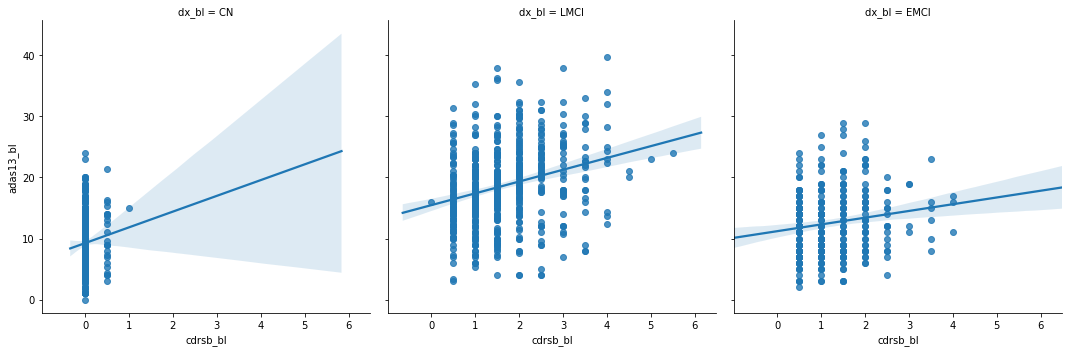

In [73]:
# plot baseline scatterplots by diagnosis group for CDRSB and ADAS13
sns.lmplot(x='cdrsb_bl', y='adas13_bl', col='dx_bl', data=bl_df);

It is difficult to interpret the CN scatterplot because there isn't much variability in the CDRSB. For the MCI groups, the correlation does appear stronger for the late MCI group. Next, we'll look at the same plots separating converts from non-converts.

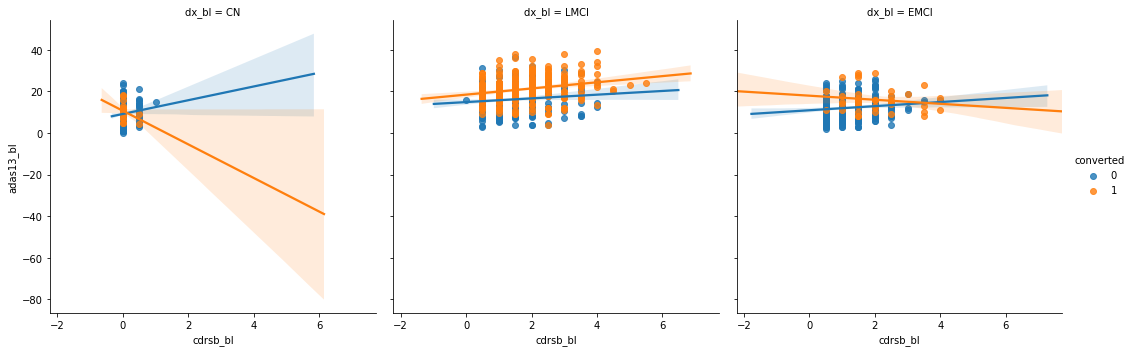

In [74]:
# plot baseline scatterplots by diagnosis group for CDRSB and ADAS13 comparing converts vs non-converts
sns.lmplot(x='cdrsb_bl', y='adas13_bl', hue='converted', col='dx_bl', data=bl_df);

The slopts for the early MCI group are different, and those for the late MCI appear similar. To model the differences the relationship between the CDRSB and the ADAS13, we'll create a new vector that represents the differences between these scores for each individual. The rationale is that the difference between the two should be held constant in a perfect correlation. We will then test whether there are statistically significant differences in this vector between groups.

In [75]:
# add new column for difference scores between CDRSB and ADAS13
df['diff_1'] = df['cdrsb_bl'] - df['adas13_bl']
bl_df['diff_1'] = bl_df['cdrsb_bl'] - bl_df['adas13_bl']

In [76]:
anova('diff_1', bl_df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 diff_1   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     221.2
Date:                Sat, 15 Sep 2018   Prob (F-statistic):          1.78e-115
Time:                        10:46:00   Log-Likelihood:                -3931.0
No. Observations:                1276   AIC:                             7870.
Df Residuals:                    1272   BIC:                             7891.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -9.1066      0.260    -35.067      0.000      -9.616      -8.597
C(dx_bl)[T.EMCI]     -1.7187      0.399     -4.306      0.000      -2.502      -0.936
C(dx_bl)[T.LMCI]     -5.9379      0.381    -15.597      0.000      -6.685      -5.191
C(converted)[T.1]    -4.0207      0.381    -10.556      0.000      -4.768      -3.273
==============================================================================
Omnibus:                       20.214   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.745
Skew:                          -0.302   Prob(JB):                     3.13e-05
Kurtosis:                       3.156   Cond. No.                         4.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
post_hoc('diff_1')

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  0      1    -0.9972  -2.945 0.9506 False 
-------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower   upper  reject
--------------------------------------------
  0      1    -3.0949  -4.863 -1.3267  True 
--------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower   upper  reject
--------------------------------------------
  0      1    -4.6619  -5.641 -3.6827  True 
--------------------------------------------




From the post-hoc tests, we can see that there are differences in the difference scores between converts and non-converts in the early and late MCI groups. Next, let's check the MMSE and the MOCA.

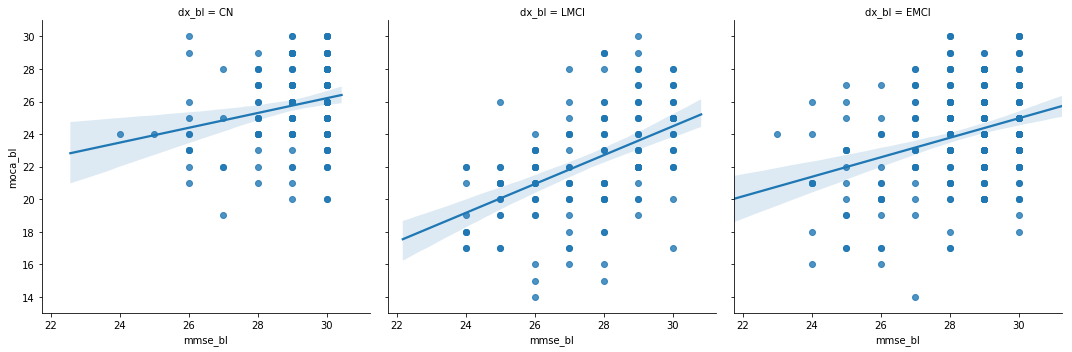

In [78]:
sns.lmplot(x='mmse_bl', y='moca_bl', col='dx_bl', data=bl_df);

Here, the slopes appear different between the diagnosis groups.

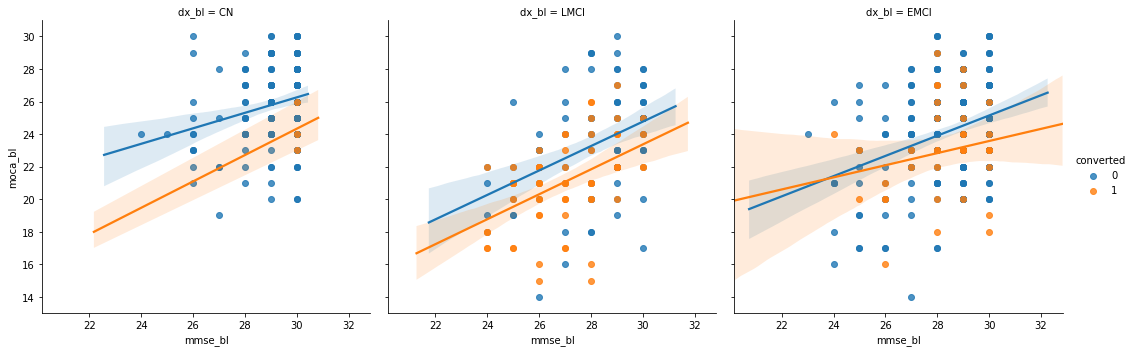

In [79]:
sns.lmplot(x='mmse_bl', y='moca_bl', hue='converted', col='dx_bl', data=bl_df);

In [80]:
# add new column for difference scores between CDRSB and ADAS13
df['diff_2'] = df['mmse_bl'] - df['moca_bl']
bl_df['diff_2'] = bl_df['mmse_bl'] - bl_df['moca_bl']

In [81]:
anova('diff_2', bl_df)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 diff_2   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     20.24
Date:                Sat, 15 Sep 2018   Prob (F-statistic):           1.53e-12
Time:                        10:46:03   Log-Likelihood:                -1555.6
No. Observations:                 647   AIC:                             3119.
Df Residuals:                     643   BIC:                             3137.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.2530      0.198     16.415      0.000       2.864       3.642
C(dx_bl)[T.EMCI]      0.9661      0.253      3.814      0.000       0.469       1.463
C(dx_bl)[T.LMCI]      1.5074      0.317      4.753      0.000       0.885       2.130
C(converted)[T.1]     1.1522      0.311      3.702      0.000       0.541       1.763
==============================================================================
Omnibus:                        2.066   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.356   Jarque-Bera (JB):                1.998
Skew:                           0.136   Prob(JB):                        0.368
Kurtosis:                       3.014   Cond. No.                         4.54
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The overall model is significant.

In [82]:
post_hoc('diff_2', drop_nan=True)

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  0      1     2.4346  -0.275 5.1442 False 
-------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  0      1     1.0372  0.0572 2.0172  True 
-------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  0      1     1.1509  0.2803 2.0215  True 
-------------------------------------------




Interestingly, we see the reverse pattern here again. The CN patients have statistical differences in difference scores between the MMSE and MOCA, but not the MCI groups.

**Summary**

Overall the baseline cognitive measures appear to have usefulness in differentiating patients that will convert to AD at some point in the study. The CDRSB, ADAS13, and MMSE are good for MCI patients, and the MOCA is good for CN patients. The difference scores between the two sets of tests appear useful as well and will be included in our final model.

#### 2.3.1.2 Ecog measures

In [83]:
bl_df.columns

Index(['rid', 'viscode', 'd1', 'd2', 'dx_bl', 'dxchange', 'age', 'ptgender',
       'pteducat', 'ptethcat', 'ptmarry', 'cdrsb_bl', 'cdrsb', 'adas13_bl',
       'adas13', 'mmse_bl', 'mmse', 'moca_bl', 'moca', 'ecogptmem_bl',
       'ecogptmem', 'ecogptvisspat_bl', 'ecogptvisspat', 'ventricles_bl',
       'wholebrain_bl', 'icv_bl', 'l_hippocampus_l', 'l_hippocampus_r',
       'x_hippocampus_l', 'x_hippocampus_r', 'l_entorhinal_l',
       'l_entorhinal_r', 'l_entorhinal_l_thick', 'l_entorhinal_r_thick',
       'x_entorhinal_l', 'x_entorhinal_r', 'x_entorhinal_l_thick',
       'x_entorhinal_r_thick', 'fdg', 'fdg_bl', 'fdg_hippocampus', 'pib',
       'pib_bl', 'av45', 'av45_bl', 'av45_hippocampus_l', 'av45_hippocampus_r',
       'av45_entorhinal_l', 'av45_entorhinal_r', 'av1451_hippocampus_l',
       'av1451_hippocampus_r', 'av1451_entorhinal_l', 'av1451_entorhinal_r',
       'fa_hippocampus_l', 'fa_hippocampus_r', 'md_hippocampus_l',
       'md_hippocampus_r', 'apoe4', 'admnrv', 'pdmnrv', 

In [84]:
# display descriptive statistics
display(dx_group['ecogptmem_bl'].describe())
display(anova('ecogptmem_bl', bl_df))

count      mean       std    min     25%    50%       75%  \
dx_bl converted                                                              
CN    0          183.0  1.528916  0.427145  1.000  1.2500  1.500  1.750000   
      1            3.0  2.029763  0.670141  1.375  1.6875  2.000  2.357145   
EMCI  0          265.0  2.217327  0.660339  1.000  1.7500  2.125  2.625000   
      1           39.0  2.430861  0.733199  1.000  1.8750  2.375  3.125000   
LMCI  0           93.0  2.294291  0.653720  1.000  1.7500  2.250  2.750000   
      1           68.0  2.485557  0.727033  1.125  2.0000  2.375  3.031250   

                     max  
dx_bl converted           
CN    0          2.87500  
      1          2.71429  
EMCI  0          4.00000  
      1          3.62500  
LMCI  0          4.00000  
      1          4.00000

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ecogptmem_bl   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     71.01
Date:                Sat, 15 Sep 2018   Prob (F-statistic):           1.04e-39
Time:                        10:46:03   Log-Likelihood:                -605.16
No. Observations:                 651   AIC:                             1218.
Df Residuals:                     647   BIC:                             1236.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.5336      0.045     34.002      0.000       1.445       1.622
C(dx_bl)[T.EMCI]      0.6838      0.058     11.834      0.000       0.570       0.797
C(dx_bl)[T.LMCI]      0.7515      0.072     10.421      0.000       0.610       0.893
C(converted)[T.1]     0.2132      0.070      3.027      0.003       0.075       0.351
==============================================================================
Omnibus:                       17.645   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.414
Skew:                           0.397   Prob(JB):                     0.000100
Kurtosis:                       2.782   Cond. No.                         4.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The overall model is significant. Let's look at the post-hoc comparisons.

In [85]:
post_hoc('ecogptmem_bl', drop_nan=True)

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  0      1     0.5008  0.0064 0.9953  True 
-------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.2135  -0.0126 0.4396 False 
--------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.1913  -0.0248 0.4073 False 
--------------------------------------------




The ecog data from the memory task appear useful in differentiating the converts from non-converts in MCI groups.

In [86]:
# display descriptive statistics
display(dx_group['ecogptvisspat_bl'].describe())
display(anova('ecogptvisspat_bl', bl_df))

count      mean       std  min      25%      50%      75%  \
dx_bl converted                                                              
CN    0          183.0  1.143508  0.279473  1.0  1.00000  1.00000  1.14286   
      1            3.0  1.047620  0.082480  1.0  1.00000  1.00000  1.07143   
EMCI  0          266.0  1.411994  0.548980  1.0  1.00000  1.14286  1.57143   
      1           39.0  1.589011  0.654182  1.0  1.07143  1.28571  2.07143   
LMCI  0           92.0  1.408540  0.534250  1.0  1.00000  1.28571  1.42857   
      1           67.0  1.551813  0.608738  1.0  1.00000  1.40000  1.85714   

                     max  
dx_bl converted           
CN    0          3.20000  
      1          1.14286  
EMCI  0          3.85714  
      1          3.42857  
LMCI  0          3.42857  
      1          3.57143

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ecogptvisspat_bl   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     18.87
Date:                Sat, 15 Sep 2018   Prob (F-statistic):           9.60e-12
Time:                        10:46:03   Log-Likelihood:                -468.73
No. Observations:                 650   AIC:                             945.5
Df Residuals:                     646   BIC:                             963.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.1396      0.037     31.122      0.000       1.068       1.211
C(dx_bl)[T.EMCI]      0.2760      0.047      5.887      0.000       0.184       0.368
C(dx_bl)[T.LMCI]      0.2665      0.059      4.539      0.000       0.151       0.382
C(converted)[T.1]     0.1491      0.057      2.599      0.010       0.036       0.262
==============================================================================
Omnibus:                      257.371   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              864.441
Skew:                           1.918   Prob(JB):                    1.95e-188
Kurtosis:                       7.149   Cond. No.                         4.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model is also statistically significant.

In [87]:
post_hoc('ecogptvisspat_bl', drop_nan=True)

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.0959  -0.4152 0.2235 False 
--------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  0      1     0.177   -0.013 0.3671 False 
-------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.1433  -0.0365 0.3231 False 
--------------------------------------------




None of the post-hoc tests were statistically significant, indicating this may not be a useful measure to differential converts. Let's include it as a measure to drop.

In [88]:
measures_to_drop.append('ecogptvisspat_bl')

#### 2.3.1.3 MRI volumetric measures

In [89]:
# display descriptive statistics
display(dx_group['ventricles_bl'].describe())
display(anova('ventricles_bl', bl_df))

count          mean           std      min      25%      50%  \
dx_bl converted                                                                 
CN    0          378.0  34360.500000  18953.656894   5834.0  20425.5  31274.0   
      1           20.0  34528.900000  16584.221969  12927.0  22673.0  31469.0   
EMCI  0          254.0  33975.440945  19157.300379   5650.0  18662.5  30157.0   
      1           39.0  44396.846154  25649.730864  10509.0  23619.5  37772.0   
LMCI  0          275.0  42343.647273  24512.806538   7801.0  24725.0  36353.0   
      1          263.0  44617.102662  22555.885576   7431.0  29027.0  40800.0   

                      75%       max  
dx_bl converted                      
CN    0          42436.75  118875.0  
      1          42586.25   72975.0  
EMCI  0          44127.25  105540.0  
      1          60616.50  122117.0  
LMCI  0          54333.50  144303.0  
      1          57500.00  145115.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ventricles_bl   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     18.43
Date:                Sat, 15 Sep 2018   Prob (F-statistic):           1.06e-11
Time:                        10:46:03   Log-Likelihood:                -13994.
No. Observations:                1229   AIC:                         2.800e+04
Df Residuals:                    1225   BIC:                         2.802e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3.419e+04   1073.143     31.861      0.000    3.21e+04    3.63e+04
C(dx_bl)[T.EMCI]    701.0560   1648.692      0.425      0.671   -2533.518    3935.630
C(dx_bl)[T.LMCI]   7537.3072   1568.848      4.804      0.000    4459.380    1.06e+04
C(converted)[T.1]  3531.1535   1560.417      2.263      0.024     469.767    6592.540
==============================================================================
Omnibus:                      269.048   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              540.340
Skew:                           1.265   Prob(JB):                    4.64e-118
Kurtosis:                       5.037   Cond. No.                         4.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
post_hoc('ventricles_bl', drop_nan=True)

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff   lower      upper   reject
--------------------------------------------------
  0      1     168.4   -8333.0926 8669.8926 False 
--------------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff    lower     upper   reject
---------------------------------------------------
  0      1    10421.4052 3609.5585 17233.252  True 
---------------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower      upper   reject
---------------------------------------------------
  0      1    2273.4554 -1720.9957 6267.9065 False 
---------------------------------------------------




The differences for the early MCI group are significant so the measure will be kept.

In [91]:
# display descriptive statistics
display(dx_group['wholebrain_bl'].describe())
display(anova('wholebrain_bl', bl_df))

count          mean            std       min        25%  \
dx_bl converted                                                            
CN    0          387.0  1.029768e+06  103079.364047  746249.0  958237.00   
      1           20.0  9.711294e+05   96752.760089  825502.0  917271.25   
EMCI  0          258.0  1.066613e+06  101200.818026  854997.0  993214.25   
      1           39.0  1.067160e+06  123824.349709  872235.0  986386.00   
LMCI  0          280.0  1.021922e+06  109510.890423  764118.0  944655.00   
      1          267.0  9.997251e+05  108964.593866  669364.0  929618.50   

                       50%        75%        max  
dx_bl converted                                   
CN    0          1033900.0  1098160.0  1309780.0  
      1           944631.5  1028887.5  1180660.0  
EMCI  0          1061485.0  1133555.0  1342720.0  
      1          1064570.0  1139575.0  1443990.0  
LMCI  0          1021040.0  1097840.0  1364230.0  
      1           997202.0  1072170.0  1350180.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          wholebrain_bl   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     20.39
Date:                Sat, 15 Sep 2018   Prob (F-statistic):           6.64e-13
Time:                        10:46:03   Log-Likelihood:                -16250.
No. Observations:                1251   AIC:                         3.251e+04
Df Residuals:                    1247   BIC:                         3.253e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.028e+06   5273.402    194.933      0.000    1.02e+06    1.04e+06
C(dx_bl)[T.EMCI]   4.159e+04   8122.695      5.120      0.000    2.57e+04    5.75e+04
C(dx_bl)[T.LMCI]  -6235.4422   7726.305     -0.807      0.420   -2.14e+04    8922.550
C(converted)[T.1] -2.179e+04   7706.937     -2.827      0.005   -3.69e+04   -6667.705
==============================================================================
Omnibus:                        7.119   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                7.223
Skew:                           0.179   Prob(JB):                       0.0270
Kurtosis:                       2.896   Cond. No.                         4.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
post_hoc('wholebrain_bl', drop_nan=True)

For diagnosis group CN, the statistical outcome is:

    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
group1 group2   meandiff     lower        upper    reject
---------------------------------------------------------
  0      1    -58638.9273 -104976.2372 -12301.6173  True 
---------------------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff    lower      upper   reject
---------------------------------------------------
  0      1    546.9595 -34749.4541 35843.373 False 
---------------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

   Multiple Comparison of Means - Tukey HSD,FWER=0.05  
group1 group2   meandiff     lower      upper    reject
-------------------------------------------------------
  0      1    -22196.4437 -40552.2143 -3840.6731  True 
-------------------------------------------------------




We see the reverse pattern here, with statistical differences in the CN and late MCI group.

In [93]:
# display descriptive statistics
display(dx_group['icv_bl'].describe())
display(anova('icv_bl', bl_df))

count          mean            std        min        25%  \
dx_bl converted                                                             
CN    0          392.0  1.518304e+06  159089.902997  1116280.0  1397900.0   
      1           20.0  1.474882e+06  157293.138058  1229440.0  1380225.0   
EMCI  0          261.0  1.501807e+06  146620.711231  1147280.0  1398870.0   
      1           39.0  1.561288e+06  176531.956014  1252780.0  1453775.0   
LMCI  0          285.0  1.558971e+06  165936.154337  1191650.0  1437350.0   
      1          270.0  1.562713e+06  170016.228629  1174860.0  1445187.5   

                       50%        75%        max  
dx_bl converted                                   
CN    0          1511085.0  1634735.0  1984660.0  
      1          1464650.0  1546622.5  1796860.0  
EMCI  0          1501970.0  1595600.0  1938020.0  
      1          1539930.0  1691335.0  2072470.0  
LMCI  0          1544810.0  1657830.0  2070410.0  
      1          1556945.0  1673237.5  2110290.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 icv_bl   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     9.267
Date:                Sat, 15 Sep 2018   Prob (F-statistic):           4.60e-06
Time:                        10:46:03   Log-Likelihood:                -16989.
No. Observations:                1267   AIC:                         3.399e+04
Df Residuals:                    1263   BIC:                         3.401e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.516e+06   7968.903    190.210      0.000     1.5e+06    1.53e+06
C(dx_bl)[T.EMCI]  -7383.3663   1.23e+04     -0.601      0.548   -3.15e+04    1.67e+04
C(dx_bl)[T.LMCI]   4.069e+04   1.17e+04      3.487      0.001    1.78e+04    6.36e+04
C(converted)[T.1]  8928.3989   1.17e+04      0.766      0.444   -1.39e+04    3.18e+04
==============================================================================
Omnibus:                       14.802   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.095
Skew:                           0.257   Prob(JB):                     0.000527
Kurtosis:                       2.854   Cond. No.                         4.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
post_hoc('icv_bl', drop_nan=True)

For diagnosis group CN, the statistical outcome is:

   Multiple Comparison of Means - Tukey HSD,FWER=0.05   
group1 group2   meandiff     lower       upper    reject
--------------------------------------------------------
  0      1    -43421.6735 -115075.4463 28232.0994 False 
--------------------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
group1 group2  meandiff    lower      upper    reject
-----------------------------------------------------
  0      1    59481.0021 8544.9632 110417.0409  True 
-----------------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
group1 group2  meandiff    lower      upper    reject
-----------------------------------------------------
  0      1    3742.0975 -24272.1196 31756.3145 False 
-----------------------------------------------------




Again, here we see for intracranial volume there are differences in converts for the earl MCI group.

In [95]:
for region in s_mri:
    print(f'Statistics for {region}.')
    # display descriptive statistics
    display(dx_group[region].describe())
    display(anova(region, bl_df))
    display(post_hoc(region, drop_nan=True))

Statistics for x_hippocampus_l.


count         mean         std     min      25%     50%  \
dx_bl converted                                                            
CN    0          392.0  3656.609694  462.826569  2460.0  3340.25  3642.5   
      1           20.0  3370.000000  439.074146  2840.0  3027.50  3257.5   
EMCI  0          260.0  3630.961538  558.274222  1225.0  3318.00  3651.0   
      1           39.0  3348.025641  425.044858  2569.0  3071.50  3258.0   
LMCI  0          285.0  3350.480702  568.651039  1604.0  2950.00  3394.0   
      1          270.0  3005.107407  528.319233  1653.0  2633.50  2994.5   

                     75%     max  
dx_bl converted                   
CN    0          3968.50  5261.0  
      1          3613.25  4491.0  
EMCI  0          4016.50  5237.0  
      1          3686.50  4070.0  
LMCI  0          3703.00  5066.0  
      1          3365.50  4884.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        x_hippocampus_l   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     100.1
Date:                Sat, 15 Sep 2018   Prob (F-statistic):           4.16e-58
Time:                        10:46:03   Log-Likelihood:                -9713.2
No. Observations:                1266   AIC:                         1.943e+04
Df Residuals:                    1262   BIC:                         1.946e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3658.6425     25.714    142.280      0.000    3608.195    3709.090
C(dx_bl)[T.EMCI]    -21.7398     39.673     -0.548      0.584     -99.571      56.092
C(dx_bl)[T.LMCI]   -316.3777     37.651     -8.403      0.000    -390.244    -242.512
C(converted)[T.1]  -328.4849     37.613     -8.733      0.000    -402.276    -254.694
==============================================================================
Omnibus:                       14.755   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               22.529
Skew:                          -0.073   Prob(JB):                     1.28e-05
Kurtosis:                       3.637   Cond. No.                         4.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower    upper   reject
-------------------------------------------------
  0      1    -286.6097 -494.6906 -78.5288  True 
-------------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower    upper   reject
-------------------------------------------------
  0      1    -282.9359 -466.4551 -99.4167  True 
-------------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower     upper   reject
--------------------------------------------------
  0      1    -345.3733 -437.0232 -253.7234  True 
--------------------------------------------------




None

Statistics for x_hippocampus_r.


count         mean         std     min      25%     50%  \
dx_bl converted                                                            
CN    0          392.0  3697.683673  491.940125  1493.0  3410.50  3735.0   
      1           20.0  3356.850000  514.679898  2549.0  2872.50  3354.5   
EMCI  0          260.0  3723.061538  521.123982  2203.0  3405.25  3749.5   
      1           39.0  3417.358974  533.139139  2295.0  3112.50  3528.0   
LMCI  0          285.0  3386.168421  574.312148  1851.0  3000.00  3378.0   
      1          270.0  3072.996296  551.233868  1628.0  2711.50  3064.5   

                    75%     max  
dx_bl converted                  
CN    0          3992.5  5508.0  
      1          3789.5  4118.0  
EMCI  0          4068.5  5044.0  
      1          3798.5  4323.0  
LMCI  0          3800.0  5060.0  
      1          3418.5  4804.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        x_hippocampus_r   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     96.33
Date:                Sat, 15 Sep 2018   Prob (F-statistic):           3.83e-56
Time:                        10:46:03   Log-Likelihood:                -9738.9
No. Observations:                1266   AIC:                         1.949e+04
Df Residuals:                    1262   BIC:                         1.951e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3696.4101     26.241    140.864      0.000    3644.929    3747.891
C(dx_bl)[T.EMCI]     27.8117     40.485      0.687      0.492     -51.614     107.237
C(dx_bl)[T.LMCI]   -309.5483     38.422     -8.056      0.000    -384.927    -234.170
C(converted)[T.1]  -314.5973     38.383     -8.196      0.000    -389.900    -239.295
==============================================================================
Omnibus:                        6.501   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                7.382
Skew:                          -0.093   Prob(JB):                       0.0250
Kurtosis:                       3.324   Cond. No.                         4.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower     upper   reject
--------------------------------------------------
  0      1    -340.8337 -563.0032 -118.6641  True 
--------------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower     upper   reject
--------------------------------------------------
  0      1    -305.7026 -482.3353 -129.0698  True 
--------------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower     upper   reject
--------------------------------------------------
  0      1    -313.1721 -407.1245 -219.2198  True 
--------------------------------------------------




None

Statistics for x_entorhinal_l.


count         mean         std     min      25%     50%  \
dx_bl converted                                                            
CN    0          392.0  1923.816327  377.922890   957.0  1689.00  1909.0   
      1           20.0  1774.350000  388.387527  1052.0  1550.75  1889.5   
EMCI  0          260.0  1962.861538  387.378363   887.0  1742.75  1980.0   
      1           39.0  1858.128205  389.037827   882.0  1596.00  1916.0   
LMCI  0          285.0  1746.185965  447.099696   569.0  1446.00  1758.0   
      1          270.0  1552.896296  438.079117   704.0  1250.25  1543.5   

                     75%     max  
dx_bl converted                   
CN    0          2123.25  3373.0  
      1          2096.75  2379.0  
EMCI  0          2189.50  3143.0  
      1          2099.00  2844.0  
LMCI  0          2064.00  3103.0  
      1          1822.00  3523.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         x_entorhinal_l   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     59.64
Date:                Sat, 15 Sep 2018   Prob (F-statistic):           4.68e-36
Time:                        10:46:03   Log-Likelihood:                -9410.3
No. Observations:                1266   AIC:                         1.883e+04
Df Residuals:                    1262   BIC:                         1.885e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1924.9715     20.241     95.102      0.000    1885.261    1964.682
C(dx_bl)[T.EMCI]     46.8286     31.228      1.500      0.134     -14.437     108.094
C(dx_bl)[T.LMCI]   -188.5287     29.637     -6.361      0.000    -246.673    -130.385
C(converted)[T.1]  -173.2619     29.607     -5.852      0.000    -231.347    -115.177
==============================================================================
Omnibus:                       22.108   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.937
Skew:                           0.251   Prob(JB):                     2.33e-06
Kurtosis:                       3.490   Cond. No.                         4.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower    upper  reject
------------------------------------------------
  0      1    -149.4663 -319.9921 21.0595 False 
------------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower    upper  reject
------------------------------------------------
  0      1    -104.7333 -235.7154 26.2487 False 
------------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower     upper   reject
--------------------------------------------------
  0      1    -193.2897 -267.1456 -119.4337  True 
--------------------------------------------------




None

Statistics for x_entorhinal_r.


count         mean         std    min      25%     50%  \
dx_bl converted                                                           
CN    0          392.0  1900.012755  381.568183  846.0  1638.00  1877.5   
      1           20.0  1750.750000  408.908287  818.0  1533.50  1683.0   
EMCI  0          260.0  1841.415385  368.526729  936.0  1596.75  1823.5   
      1           39.0  1704.948718  503.729927  657.0  1357.50  1585.0   
LMCI  0          285.0  1746.642105  408.060577  673.0  1495.00  1729.0   
      1          270.0  1549.833333  442.643493  562.0  1274.25  1480.0   

                     75%     max  
dx_bl converted                   
CN    0          2159.50  3602.0  
      1          2074.25  2523.0  
EMCI  0          2064.75  3090.0  
      1          2013.00  3125.0  
LMCI  0          1994.00  3294.0  
      1          1808.25  2980.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         x_entorhinal_r   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     43.59
Date:                Sat, 15 Sep 2018   Prob (F-statistic):           8.37e-27
Time:                        10:46:03   Log-Likelihood:                -9389.3
No. Observations:                1266   AIC:                         1.879e+04
Df Residuals:                    1262   BIC:                         1.881e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1901.5731     19.908     95.516      0.000    1862.516    1940.630
C(dx_bl)[T.EMCI]    -54.2961     30.715     -1.768      0.077    -114.554       5.962
C(dx_bl)[T.LMCI]   -162.4245     29.150     -5.572      0.000    -219.613    -105.236
C(converted)[T.1]  -181.4054     29.121     -6.229      0.000    -238.536    -124.275
==============================================================================
Omnibus:                       53.784   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.216
Skew:                           0.423   Prob(JB):                     5.66e-16
Kurtosis:                       3.785   Cond. No.                         4.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower    upper  reject
------------------------------------------------
  0      1    -149.2628 -321.8002 23.2747 False 
------------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower    upper  reject
------------------------------------------------
  0      1    -136.4667 -267.7423 -5.1911  True 
------------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower     upper   reject
--------------------------------------------------
  0      1    -196.8088 -267.7454 -125.8722  True 
--------------------------------------------------




None

Statistics for x_entorhinal_l_thick.


count      mean       std    min      25%     50%      75%  \
dx_bl converted                                                               
CN    0          392.0  3.419901  0.334183  2.237  3.22675  3.4405  3.65525   
      1           20.0  3.290600  0.346355  2.687  3.06575  3.2840  3.58975   
EMCI  0          260.0  3.404819  0.413315  1.832  3.17475  3.4895  3.68575   
      1           39.0  3.186615  0.482791  2.087  2.99900  3.2870  3.52000   
LMCI  0          285.0  3.176407  0.499605  1.715  2.83400  3.2690  3.54300   
      1          270.0  2.943248  0.520365  1.572  2.62975  2.9920  3.29525   

                   max  
dx_bl converted         
CN    0          4.432  
      1          3.847  
EMCI  0          4.412  
      1          3.843  
LMCI  0          4.128  
      1          4.115

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     x_entorhinal_l_thick   R-squared:                       0.155
Model:                              OLS   Adj. R-squared:                  0.153
Method:                   Least Squares   F-statistic:                     77.06
Date:                  Sat, 15 Sep 2018   Prob (F-statistic):           9.00e-46
Time:                          10:46:04   Log-Likelihood:                -751.46
No. Observations:                  1266   AIC:                             1511.
Df Residuals:                      1262   BIC:                             1531.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.4243      0.022    158.012      0.000       3.382       3.467
C(dx_bl)[T.EMCI]     -0.0192      0.033     -0.575      0.565      -0.085       0.046
C(dx_bl)[T.LMCI]     -0.2542      0.032     -8.011      0.000      -0.316      -0.192
C(converted)[T.1]    -0.2202      0.032     -6.946      0.000      -0.282      -0.158
==============================================================================
Omnibus:                       61.200   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.182
Skew:                          -0.547   Prob(JB):                     9.49e-16
Kurtosis:                       3.341   Cond. No.                         4.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.1293  -0.2802 0.0216 False 
--------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -0.2182  -0.3611 -0.0753  True 
---------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -0.2332  -0.3182 -0.1481  True 
---------------------------------------------




None

Statistics for x_entorhinal_r_thick.


count      mean       std    min      25%     50%      75%  \
dx_bl converted                                                               
CN    0          392.0  3.567911  0.343846  2.305  3.36025  3.5995  3.79550   
      1           20.0  3.366600  0.479787  2.104  3.03725  3.2830  3.70425   
EMCI  0          260.0  3.557788  0.462479  1.755  3.33025  3.6180  3.87050   
      1           39.0  3.261872  0.590128  1.511  3.08500  3.4190  3.59550   
LMCI  0          285.0  3.360589  0.496323  2.086  3.03400  3.3890  3.70500   
      1          270.0  3.066996  0.506158  1.454  2.75175  3.1290  3.40225   

                   max  
dx_bl converted         
CN    0          4.522  
      1          4.088  
EMCI  0          4.611  
      1          4.113  
LMCI  0          4.508  
      1          4.279

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     x_entorhinal_r_thick   R-squared:                       0.158
Model:                              OLS   Adj. R-squared:                  0.156
Method:                   Least Squares   F-statistic:                     79.05
Date:                  Sat, 15 Sep 2018   Prob (F-statistic):           7.36e-47
Time:                          10:46:04   Log-Likelihood:                -790.12
No. Observations:                  1266   AIC:                             1588.
Df Residuals:                      1262   BIC:                             1609.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.5720      0.022    159.868      0.000       3.528       3.616
C(dx_bl)[T.EMCI]     -0.0156      0.034     -0.453      0.650      -0.083       0.052
C(dx_bl)[T.LMCI]     -0.2156      0.033     -6.591      0.000      -0.280      -0.151
C(converted)[T.1]    -0.2848      0.033     -8.715      0.000      -0.349      -0.221
==============================================================================
Omnibus:                       84.517   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.859
Skew:                          -0.617   Prob(JB):                     1.70e-23
Kurtosis:                       3.683   Cond. No.                         4.22
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.2013  -0.3596 -0.043  True 
--------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -0.2959  -0.4584 -0.1335  True 
---------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper reject
-------------------------------------------
  0      1    -0.2936  -0.3772 -0.21  True 
-------------------------------------------




None

The measures for the hippocampus seem to best differentiate, although volume and thickness in the entorhinal statistically differentiates converts as well.

#### 2.3.1.4 fMRI functional connectivity measures

In [96]:
display(dx_group['admnrv'].describe())
display(anova('admnrv', bl_df))

count      mean       std      min       25%      50%  \
dx_bl converted                                                          
CN    0           33.0  0.602789  0.108349  0.34026  0.558770  0.60629   
      1            0.0       NaN       NaN      NaN       NaN      NaN   
EMCI  0           41.0  0.627351  0.115112  0.42930  0.528570  0.63006   
      1            8.0  0.567089  0.045784  0.47986  0.545865  0.57124   
LMCI  0           19.0  0.599005  0.113714  0.31701  0.558350  0.61229   
      1           13.0  0.595092  0.133120  0.35812  0.549880  0.57594   

                      75%      max  
dx_bl converted                     
CN    0          0.659990  0.79159  
      1               NaN      NaN  
EMCI  0          0.708670  0.85752  
      1          0.595468  0.62564  
LMCI  0          0.692050  0.71976  
      1          0.619570  0.83879

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 admnrv   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.5842
Date:                Sat, 15 Sep 2018   Prob (F-statistic):              0.627
Time:                        10:46:04   Log-Likelihood:                 89.963
No. Observations:                 114   AIC:                            -171.9
Df Residuals:                     110   BIC:                            -161.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6028      0.019     30.948      0.000       0.564       0.641
C(dx_bl)[T.EMCI]      0.0196      0.026      0.765      0.446      -0.031       0.070
C(dx_bl)[T.LMCI]      0.0068      0.030      0.227      0.821      -0.053       0.067
C(converted)[T.1]    -0.0301      0.029     -1.021      0.310      -0.088       0.028
==============================================================================
Omnibus:                        0.594   Durbin-Watson:                   1.744
Prob(Omnibus):                  0.743   Jarque-Bera (JB):                0.548
Skew:                          -0.166   Prob(JB):                        0.760
Kurtosis:                       2.926   Cond. No.                         4.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The model was not statistically significant, indicating it is not a useful metric to differentiate converts.

In [97]:
measures_to_drop.append('admnrv')

In [98]:
display(dx_group['pdmnrv'].describe())
display(anova('pdmnrv', bl_df))

count      mean       std      min       25%      50%  \
dx_bl converted                                                          
CN    0           33.0  0.641108  0.150384  0.41190  0.516210  0.61951   
      1            0.0       NaN       NaN      NaN       NaN      NaN   
EMCI  0           41.0  0.645031  0.106238  0.45537  0.566750  0.63526   
      1            8.0  0.617984  0.078996  0.54170  0.577222  0.59644   
LMCI  0           19.0  0.590223  0.125362  0.35383  0.554135  0.58477   
      1           13.0  0.634875  0.081632  0.51157  0.565880  0.65893   

                      75%      max  
dx_bl converted                     
CN    0          0.743690  1.08620  
      1               NaN      NaN  
EMCI  0          0.726750  0.87003  
      1          0.627458  0.78947  
LMCI  0          0.614990  0.86799  
      1          0.692720  0.75358

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pdmnrv   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.5981
Date:                Sat, 15 Sep 2018   Prob (F-statistic):              0.618
Time:                        10:46:04   Log-Likelihood:                 81.410
No. Observations:                 114   AIC:                            -154.8
Df Residuals:                     110   BIC:                            -143.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6411      0.021     30.536      0.000       0.599       0.683
C(dx_bl)[T.EMCI]     -0.0023      0.028     -0.085      0.933      -0.057       0.052
C(dx_bl)[T.LMCI]     -0.0374      0.033     -1.146      0.254      -0.102       0.027
C(converted)[T.1]     0.0114      0.032      0.357      0.722      -0.052       0.074
==============================================================================
Omnibus:                        5.711   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                5.348
Skew:                           0.407   Prob(JB):                       0.0690
Kurtosis:                       3.681   Cond. No.                         4.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Again, the omnibus model is not statistically significant and the measure will be dropped.

In [99]:
measures_to_drop.append('pdmnrv')

In [100]:
display(dx_group['dmnrvr'].describe())
display(anova('dmnrvr', bl_df))

count      mean       std      min       25%       50%  \
dx_bl converted                                                           
CN    0           33.0  0.973052  0.218382  0.54079  0.826080  0.952180   
      1            0.0       NaN       NaN      NaN       NaN       NaN   
EMCI  0           41.0  0.985737  0.184229  0.61964  0.859640  0.935830   
      1            8.0  0.927654  0.118086  0.77272  0.808360  0.952775   
LMCI  0           19.0  1.041359  0.235692  0.65135  0.891095  1.063300   
      1           13.0  0.939295  0.186889  0.63286  0.819440  0.908090   

                     75%     max  
dx_bl converted                   
CN    0          1.10060  1.4246  
      1              NaN     NaN  
EMCI  0          1.08740  1.4362  
      1          1.02205  1.0658  
LMCI  0          1.16220  1.6527  
      1          1.06880  1.2542

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 dmnrvr   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9198
Date:                Sat, 15 Sep 2018   Prob (F-statistic):              0.434
Time:                        10:46:04   Log-Likelihood:                 23.658
No. Observations:                 114   AIC:                            -39.32
Df Residuals:                     110   BIC:                            -28.37
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.9731      0.035     27.926      0.000       0.904       1.042
C(dx_bl)[T.EMCI]      0.0165      0.046      0.360      0.719      -0.074       0.107
C(dx_bl)[T.LMCI]      0.0600      0.054      1.110      0.270      -0.047       0.167
C(converted)[T.1]    -0.0816      0.053     -1.548      0.124      -0.186       0.023
==============================================================================
Omnibus:                        2.840   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.242   Jarque-Bera (JB):                2.484
Skew:                           0.359   Prob(JB):                        0.289
Kurtosis:                       3.078   Cond. No.                         4.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The final functional connectivity measure was not statistically significant either and will be dropped.

In [101]:
measures_to_drop.append('dmnrvr')

#### 2.3.1.5 DTI measures

In [102]:
for region in dti:
    print(f'Statistics for {region}.')
    # display descriptive statistics
    display(dx_group[region].describe())
    display(anova(region, bl_df))
    display(post_hoc(region, drop_nan=True))

Statistics for fa_hippocampus_l.


count      mean       std       min       25%       50%  \
dx_bl converted                                                            
CN    0           44.0  0.241095  0.022925  0.190105  0.227880  0.242339   
      1            2.0  0.221531  0.022830  0.205388  0.213460  0.221531   
EMCI  0           53.0  0.231854  0.026933  0.174560  0.209867  0.234488   
      1           10.0  0.223332  0.037240  0.188631  0.197283  0.214953   
LMCI  0           17.0  0.235066  0.037292  0.163519  0.218240  0.231142   
      1           16.0  0.229807  0.030500  0.177474  0.210953  0.231745   

                      75%       max  
dx_bl converted                      
CN    0          0.255830  0.289383  
      1          0.229603  0.237675  
EMCI  0          0.248885  0.314793  
      1          0.237941  0.309860  
LMCI  0          0.258822  0.303925  
      1          0.253154  0.286827

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       fa_hippocampus_l   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.628
Date:                Sat, 15 Sep 2018   Prob (F-statistic):              0.186
Time:                        10:46:04   Log-Likelihood:                 307.19
No. Observations:                 142   AIC:                            -606.4
Df Residuals:                     138   BIC:                            -594.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2406      0.004     57.705      0.000       0.232       0.249
C(dx_bl)[T.EMCI]     -0.0088      0.006     -1.593      0.114      -0.020       0.002
C(dx_bl)[T.LMCI]     -0.0041      0.007     -0.582      0.562      -0.018       0.010
C(converted)[T.1]    -0.0082      0.007     -1.254      0.212      -0.021       0.005
==============================================================================
Omnibus:                        3.332   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.189   Jarque-Bera (JB):                2.817
Skew:                           0.281   Prob(JB):                        0.245
Kurtosis:                       3.401   Cond. No.                         4.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  0      1    -0.0196  -0.053 0.0138 False 
-------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.0085  -0.0283 0.0113 False 
--------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper reject
-------------------------------------------
  0      1    -0.0053  -0.0295 0.019 False 
-------------------------------------------




None

Statistics for fa_hippocampus_r.


count      mean       std       min       25%       50%  \
dx_bl converted                                                            
CN    0           44.0  0.266563  0.025748  0.177648  0.251764  0.269305   
      1            2.0  0.228067  0.027539  0.208594  0.218331  0.228067   
EMCI  0           53.0  0.264071  0.027410  0.213355  0.244931  0.261789   
      1           10.0  0.255539  0.050205  0.194743  0.224569  0.248630   
LMCI  0           17.0  0.272123  0.035840  0.206412  0.248067  0.272872   
      1           16.0  0.270051  0.026791  0.229996  0.247608  0.270581   

                      75%       max  
dx_bl converted                      
CN    0          0.280901  0.332891  
      1          0.237804  0.247540  
EMCI  0          0.277508  0.353116  
      1          0.278079  0.362394  
LMCI  0          0.298675  0.325774  
      1          0.292473  0.306485

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       fa_hippocampus_r   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.097
Date:                Sat, 15 Sep 2018   Prob (F-statistic):              0.353
Time:                        10:46:04   Log-Likelihood:                 298.36
No. Observations:                 142   AIC:                            -588.7
Df Residuals:                     138   BIC:                            -576.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.2653      0.004     59.784      0.000       0.256       0.274
C(dx_bl)[T.EMCI]     -0.0012      0.006     -0.198      0.843      -0.013       0.010
C(dx_bl)[T.LMCI]      0.0101      0.008      1.344      0.181      -0.005       0.025
C(converted)[T.1]    -0.0088      0.007     -1.256      0.211      -0.023       0.005
==============================================================================
Omnibus:                        6.339   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                7.747
Skew:                           0.271   Prob(JB):                       0.0208
Kurtosis:                       4.008   Cond. No.                         4.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -0.0385  -0.0761 -0.0009  True 
---------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.0085  -0.0305 0.0134 False 
--------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.0021  -0.0247 0.0205 False 
--------------------------------------------




None

Statistics for md_hippocampus_l.


count      mean       std       min       25%       50%  \
dx_bl converted                                                            
CN    0           44.0  0.000892  0.000071  0.000755  0.000851  0.000884   
      1            2.0  0.000858  0.000049  0.000823  0.000841  0.000858   
EMCI  0           53.0  0.000948  0.000099  0.000785  0.000870  0.000931   
      1           10.0  0.001013  0.000130  0.000758  0.000986  0.001004   
LMCI  0           17.0  0.000955  0.000114  0.000796  0.000860  0.000951   
      1           16.0  0.000991  0.000109  0.000845  0.000935  0.000981   

                      75%       max  
dx_bl converted                      
CN    0          0.000930  0.001063  
      1          0.000875  0.000893  
EMCI  0          0.001016  0.001251  
      1          0.001033  0.001240  
LMCI  0          0.001041  0.001158  
      1          0.001019  0.001239

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       md_hippocampus_l   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     7.250
Date:                Sat, 15 Sep 2018   Prob (F-statistic):           0.000149
Time:                        10:46:04   Log-Likelihood:                 1113.7
No. Observations:                 142   AIC:                            -2219.
Df Residuals:                     138   BIC:                            -2208.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0009   1.42e-05     62.411      0.000       0.001       0.001
C(dx_bl)[T.EMCI]   6.307e-05   1.89e-05      3.345      0.001    2.58e-05       0.000
C(dx_bl)[T.LMCI]   6.359e-05   2.41e-05      2.640      0.009     1.6e-05       0.000
C(converted)[T.1]  4.195e-05   2.24e-05      1.877      0.063   -2.25e-06    8.61e-05
==============================================================================
Omnibus:                        5.591   Durbin-Watson:                   2.166
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                5.247
Skew:                           0.463   Prob(JB):                       0.0725
Kurtosis:                       3.171   Cond. No.                         4.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1      -0.0   -0.0001 0.0001 False 
--------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower upper  reject
------------------------------------------
  0      1     0.0001   -0.0 0.0001 False 
------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower upper  reject
------------------------------------------
  0      1      0.0     -0.0 0.0001 False 
------------------------------------------




None

Statistics for md_hippocampus_r.


count      mean       std       min       25%       50%  \
dx_bl converted                                                            
CN    0           44.0  0.000917  0.000100  0.000790  0.000856  0.000910   
      1            2.0  0.001009  0.000151  0.000901  0.000955  0.001009   
EMCI  0           53.0  0.000919  0.000087  0.000769  0.000850  0.000905   
      1           10.0  0.001034  0.000129  0.000850  0.000961  0.000995   
LMCI  0           17.0  0.000915  0.000086  0.000789  0.000846  0.000909   
      1           16.0  0.000963  0.000080  0.000836  0.000892  0.000941   

                      75%       max  
dx_bl converted                      
CN    0          0.000965  0.001407  
      1          0.001062  0.001116  
EMCI  0          0.000976  0.001105  
      1          0.001167  0.001193  
LMCI  0          0.000981  0.001074  
      1          0.001038  0.001086

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       md_hippocampus_r   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     5.100
Date:                Sat, 15 Sep 2018   Prob (F-statistic):            0.00223
Time:                        10:46:04   Log-Likelihood:                 1116.7
No. Observations:                 142   AIC:                            -2225.
Df Residuals:                     138   BIC:                            -2214.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0009   1.39e-05     65.802      0.000       0.001       0.001
C(dx_bl)[T.EMCI]   6.959e-06   1.85e-05      0.377      0.707   -2.96e-05    4.35e-05
C(dx_bl)[T.LMCI]  -1.909e-05   2.36e-05     -0.809      0.420   -6.57e-05    2.76e-05
C(converted)[T.1]  8.282e-05   2.19e-05      3.783      0.000    3.95e-05       0.000
==============================================================================
Omnibus:                       43.816   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.402
Skew:                           1.191   Prob(JB):                     2.63e-27
Kurtosis:                       6.874   Cond. No.                         4.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1     0.0001  -0.0001 0.0002 False 
--------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower upper  reject
------------------------------------------
  0      1     0.0001   0.0  0.0002  True 
------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower upper  reject
------------------------------------------
  0      1      0.0     -0.0 0.0001 False 
------------------------------------------




None

Based on these results, it appears that fractional anisotropy and mean diffusivity in the right hippocampus are able to differentiate converts, but not in the left hippocampus.

In [104]:
for region in ['fa_hippocampus_l', 'fa_hippocampus_r', 'md_hippocampus_l']:
    measures_to_drop.append(region)

#### 2.3.1.6 PET measures

The measures we identified in our preliminary analysis were AV45 and FDG at baseline. Let's now check if there are statistical differences in these between converts and non-converts.

In [105]:
for measure in ['av45_bl', 'fdg_bl']:
    print(f'Statistics for {measure}.')
    # display descriptive statistics
    display(dx_group[measure].describe())
    display(anova(measure, bl_df))
    display(post_hoc(measure, drop_nan=True))

Statistics for av45_bl.


count      mean       std       min       25%       50%  \
dx_bl converted                                                            
CN    0          180.0  1.111956  0.176968  0.880500  1.002815  1.056490   
      1            3.0  1.100285  0.189569  0.987712  0.990852  0.993992   
EMCI  0          263.0  1.150174  0.193682  0.876018  1.005735  1.068070   
      1           39.0  1.333829  0.208732  0.938612  1.205690  1.368140   
LMCI  0           89.0  1.192104  0.212132  0.868518  1.018480  1.125370   
      1           67.0  1.416627  0.212310  0.838537  1.292835  1.438700   

                      75%      max  
dx_bl converted                     
CN    0          1.172965  2.02556  
      1          1.156571  1.31915  
EMCI  0          1.268715  1.84169  
      1          1.469500  1.73615  
LMCI  0          1.353690  1.77582  
      1          1.535065  1.99501

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                av45_bl   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     49.01
Date:                Sat, 15 Sep 2018   Prob (F-statistic):           1.65e-28
Time:                        10:46:49   Log-Likelihood:                 139.84
No. Observations:                 641   AIC:                            -271.7
Df Residuals:                     637   BIC:                            -253.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.1085      0.014     76.817      0.000       1.080       1.137
C(dx_bl)[T.EMCI]      0.0399      0.018      2.164      0.031       0.004       0.076
C(dx_bl)[T.LMCI]      0.0955      0.023      4.114      0.000       0.050       0.141
C(converted)[T.1]     0.1968      0.023      8.740      0.000       0.153       0.241
==============================================================================
Omnibus:                       81.593   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              115.287
Skew:                           0.906   Prob(JB):                     9.24e-26
Kurtosis:                       4.018   Cond. No.                         4.55
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.0117  -0.2151 0.1918 False 
--------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  0      1     0.1837  0.1176 0.2497  True 
-------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff lower  upper  reject
-------------------------------------------
  0      1     0.2245  0.1567 0.2923  True 
-------------------------------------------




None

Statistics for fdg_bl.


count      mean       std       min       25%       50%  \
dx_bl converted                                                            
CN    0          275.0  1.307035  0.112679  0.990562  1.232560  1.304730   
      1           11.0  1.257857  0.146128  1.100650  1.164135  1.242320   
EMCI  0          263.0  1.300267  0.113694  0.969056  1.230035  1.299880   
      1           39.0  1.194739  0.113939  0.988192  1.102210  1.205100   
LMCI  0          192.0  1.251318  0.138849  0.767384  1.156590  1.253485   
      1          168.0  1.167459  0.116660  0.782496  1.099173  1.165975   

                      75%      max  
dx_bl converted                     
CN    0          1.371175  1.61685  
      1          1.291185  1.63446  
EMCI  0          1.371335  1.67050  
      1          1.281315  1.43863  
LMCI  0          1.340765  1.70717  
      1          1.236510  1.48114

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 fdg_bl   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     60.63
Date:                Sat, 15 Sep 2018   Prob (F-statistic):           7.54e-36
Time:                        10:46:49   Log-Likelihood:                 668.20
No. Observations:                 948   AIC:                            -1328.
Df Residuals:                     944   BIC:                            -1309.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             1.3085      0.007    184.374      0.000       1.295       1.322
C(dx_bl)[T.EMCI]     -0.0107      0.010     -1.072      0.284      -0.030       0.009
C(dx_bl)[T.LMCI]     -0.0559      0.010     -5.334      0.000      -0.076      -0.035
C(converted)[T.1]    -0.0866      0.010     -8.371      0.000      -0.107      -0.066
==============================================================================
Omnibus:                       10.365   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               14.621
Skew:                           0.087   Prob(JB):                     0.000669
Kurtosis:                       3.583   Cond. No.                         4.26
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For diagnosis group CN, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.0492  -0.1182 0.0198 False 
--------------------------------------------


For diagnosis group EMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -0.1055  -0.1439 -0.0671  True 
---------------------------------------------


For diagnosis group LMCI, the statistical outcome is:

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1    -0.0839  -0.1107 -0.0571  True 
---------------------------------------------




None

The PET measures appear useful for differentiating the MCI groups and will be kept.

#### 2.3.2 Summary

Performance on the cognitive assessments and the volumetric brain measures appear to best differentiate the converts from non-converts in the dataset. These will be used as features in the primary model and we will subsample from this dataset to include the other measures when comparing model performance.

In [111]:
### drop measures
print(measures_to_drop)

['ecogptmem_bl', 'ecogptvisspat_bl', 'fa_hippocampus_l', 'fa_hippocampus_r', 'fdg_hippocampus', 'pib_bl', 'av45_hippocampus_l', 'av45_hippocampus_r', 'av45_entorhinal_l', 'av45_entorhinal_r', 'av1451_hippocampus_l', 'av1451_hippocampus_r', 'av1451_entorhinal_l', 'av1451_entorhinal_r', 'ecogptvisspat_bl', 'admnrv', 'pdmnrv', 'dmnrvr', 'fa_hippocampus_l', 'fa_hippocampus_r', 'md_hippocampus_l', 'moca_bl']


In [115]:
# drop unwanted features
df.drop(measures_to_drop, axis=1, inplace=True)

# create structural MRI baseline feature columns
areas = ['x_hippocampus_l', 'x_hippocampus_r', 'x_entorhinal_l', 'x_entorhinal_r', 'x_entorhinal_l_thick', 'x_entorhinal_r_thick']

for p in df.rid.unique():
    for area in areas:
        df.loc[df.rid==p, area+'_bl'] = df.loc[(df.rid==p) & (df.viscode==0), area]

for area in areas:
    df[area+'_bl'].fillna(method='ffill', inplace=True)
    
# save dataframe
df.to_csv('df_final.csv')